# Lymphatic spread data oropharynx patients data analysis

In [71]:
from requirements_midplane import *

## Load data

In [72]:
def open_gzip_file(gzip_file_path):
    """
    Open a gzip file and return its content.

    Parameters:
    gzip_file_path (str): The path to the gzip file.

    Returns:
    bytes: The content of the gzip file.
    """
    try:
        with gzip.open(gzip_file_path, 'rb') as f_in:
            file_content = f_in.read()
        return file_content
    except Exception as e:
        print(f'Error opening {gzip_file_path}: {e}')
        return None

def load_nifti_file(file_path):
    """
    Load a NIfTI file and return the image data.
    
    Parameters:
    file_path (str): Path to the NIfTI file.
    
    Returns:
    numpy.ndarray: The image data.
    """
    import nibabel as nib

    nifti_img = nib.load(file_path)
    img_data = nifti_img.get_fdata()
    voxel_size = nifti_img.header.get_zooms()
    
    return img_data, voxel_size

def get_image_and_voxel_size_from_gzip(gzip_file_path):
    """
    Get the image array and voxel size from a gzipped NIfTI file.

    Parameters:
    gzip_file_path (str): Path to the gzipped NIfTI file.

    Returns:
    tuple: The image array and voxel size.
    """

    file_content = open_gzip_file(gzip_file_path)
    if file_content is not None:
        with open('temp_nifti.nii', 'wb') as temp_file:
            temp_file.write(file_content)

        # 🔹 Debugging: Check if the file was actually written
        file_size = os.path.getsize('temp_nifti.nii')
        if file_size == 0:
            print(f"❌ Error: 'temp_nifti.nii' was written but is empty! ({gzip_file_path})")
            return None, None
        else:
            print(f"✅ Success: 'temp_nifti.nii' was written successfully ({file_size} bytes).")

        img_data, voxel_size = load_nifti_file('temp_nifti.nii')
        os.remove('temp_nifti.nii')  # Remove temp file after reading
        
        return img_data, voxel_size
    else:
        print(f"❌ Error: Failed to read file content from '{gzip_file_path}'")
        return None, None

def load_patient_data_from_row(row, root_folder):
    """
    Given one row from the CSV and the root folder containing patient folders,
    load the patient's main image and structure files as specified by the row.
    
    The CSV is expected to have headers:
      Patient ID, Extention, Position, GTVp, Body, Mandible, Spinal Cord.
      
    For the patient:
      - The patient folder is assumed to be located at root_folder/patient_id,
        where patient_id is the Patient ID padded to 8 digits (with any decimals removed).
      - The main image is loaded from "image.nii.gz" (searched recursively).
      - For each structure column (GTVp, Body, Mandible, Spinal Cord), if the CSV cell is non-empty,
        the function searches recursively for a file whose name exactly matches the cell value.
      - Each loaded NIfTI file is transposed using np.transpose(array, (1, 0, 2)).
      
    Parameters
    ----------
    row : pandas.Series
        One row from the CSV file.
    root_folder : str
        The root folder that contains patient folders (named by padded patient IDs).
    
    Returns
    -------
    tuple or (None, patient_id)
        If successful, returns a tuple (patient_data, patient_id) where patient_data is a dictionary
        with keys such as "Image", "GTVp", "Body", "Mandible", and "Spinal Cord" mapping to a tuple
        (image_array, voxel_size). If the main image cannot be loaded or the patient folder is missing,
        returns (None, patient_id).
    """
    # Convert Patient ID to a float, then to an int to remove decimals, and pad to 8 digits.
    try:
        pid_num = float(row["Patient ID"])
        patient_id = str(int(pid_num)).zfill(8)
    except Exception as e:
        print(f"Invalid Patient ID '{row['Patient ID']}' in row, skipping.")
        return None, None

    # Build the patient folder path.
    patient_folder = os.path.join(root_folder, patient_id)
    if not os.path.isdir(patient_folder):
        print(f"Patient folder {patient_folder} not found for patient {patient_id}.")
        return None, patient_id

    pdata = {}

    # 1. Load the main image ("image.nii.gz")
    main_image_path = None
    for root_dir, dirs, files in os.walk(patient_folder):
        if "image.nii.gz" in files:
            main_image_path = os.path.join(root_dir, "image.nii.gz")
            break
    if main_image_path is None:
        print(f"Main image 'image.nii.gz' not found for patient {patient_id}.")
        return None, patient_id

    img_data, voxel_size = get_image_and_voxel_size_from_gzip(main_image_path)
    if img_data is None:
        print(f"Failed to load main image for patient {patient_id}.")
        return None, patient_id
    # Transpose the array as required.
    img_data = np.transpose(img_data, (1, 0, 2))
    pdata["Image"] = (img_data, voxel_size)

    # 2. Process structure columns.
    structure_columns = ["GTVp"]#, "Body", "Mandible", "Spinal Cord"]
    for col in structure_columns:
        file_name = str(row[col]).strip()
        if not file_name or file_name.lower() in ['nan', '']:
            continue  # Skip empty entries.
        
        structure_file_path = None
        # Search recursively in the patient folder for an exact filename match (case-insensitive).
        for root_dir, dirs, files in os.walk(patient_folder):
            for f in files:
                if f.lower() == file_name.lower():
                    structure_file_path = os.path.join(root_dir, f)
                    break
            if structure_file_path is not None:
                break
        
        if structure_file_path is None:
            print(f"File for structure '{col}' with name '{file_name}' not found for patient {patient_id}.")
            continue
        
        # Load the structure file.
        if structure_file_path.endswith(".nii.gz"):
            struct_img, struct_voxel_size = get_image_and_voxel_size_from_gzip(structure_file_path)
            
        else:
            struct_img, struct_voxel_size = load_nifti_file(structure_file_path)
        if struct_img is None:
            print(f"Failed to load structure '{col}' for patient {patient_id} from {structure_file_path}.")
            continue
        
        # Transpose the array.
        struct_img = np.transpose(struct_img, (1, 0, 2))
        pdata[col] = (struct_img, struct_voxel_size)
        print(f"Loaded {col} from {structure_file_path}")
    
    return pdata, patient_id

import pickle

def save_patient_structures(df, base_path, save_dir):
    """
    Process each patient row in the DataFrame `df`, load the arrays for each structure,
    and save them in a dictionary with the CSV row index as the first key and the structure 
    names as second-level keys. The resulting dictionary is saved to `save_dir` for fast future use.
    
    The resulting dictionary will look like:
    
        {
           idx: {
               "Patient ID": <formatted patient id>,
               "Image": <numpy array or None>,
               "Body": <numpy array or None>,
               "GTVp": <numpy array or None>,
               "Mandible": <numpy array or None>,
               "Spinal Cord": <numpy array or None>
           },
           ...
        }
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing patient rows (must include columns "Patient ID" and "GTVp").
        base_path (str): Base directory for loading patient data (passed to load_patient_data_from_row).
        save_dir (str): Directory where the aggregated dictionary will be saved.
        patient_range (tuple, optional): A tuple (start_idx, end_idx) specifying a range of indices to process.
    
    Returns:
        dict: The aggregated dictionary of patient structures.
    """
    aggregated = {}
    
    # Ensure the output directory exists.
    os.makedirs(save_dir, exist_ok=True)
    
    for idx, row in df.iterrows():
        # Format patient ID from the first column ("Patient ID")
        pat_id = row['Patient ID']
        pat_id = str(pat_id).zfill(8)
        
        # Check for missing critical info.
        if pd.isna(pat_id) or pd.isna(row['GTVp']):
            continue
        
        print(f"Processing patient {pat_id} at CSV row {idx}...")
        
        # Load patient data.
        pdata, pid = load_patient_data_from_row(row, base_path)
        if pdata is None or pid is None:
            print(f"Failed to load data for patient at CSV row {idx}.")
            continue
        else:
            # Extract arrays from the data.
            # Each call expects a tuple (array, voxel_size) where we need only the array.
            image    = pdata.get("Image",    (None,))[0]
            body     = pdata.get("Body",     (None,))[0]
            gtvp     = pdata.get("GTVp",     (None,))[0]
            # Mandible, Body, and Spinal Cord can be None.
            mandibula  = pdata.get("Mandible", (None,))[0]
            spinalcord = pdata.get("Spinal Cord", (None,))[0]
            
            # Check for required data.
            if image is None or gtvp is None:
                print(f"Patient {pid} is missing required data (Image or GTVp). Skipping...")
                continue
            
            print(f"Patient {pid} data loaded successfully.")
            
            # Save data for this patient in the aggregated dictionary.
            aggregated[idx] = {
                "Patient ID": pat_id,
                "Image": image,
                "Body": body,
                "GTVp": gtvp,
                "Mandible": mandibula,
                "Spinal Cord": spinalcord
            }
    
    # Save the aggregated dictionary to a file for fast future loading.
    output_file = os.path.join(save_dir, "patient_structures_dict.pkl")
    with open(output_file, "wb") as f:
        pickle.dump(aggregated, f)
    
    print(f"Aggregated patient structures saved to {output_file}")
    return aggregated

def load_patient_structures_by_idx(idx, save_dir):
    """
    Load the stored patient structures for a given patient index.
    
    The function assumes that the aggregated data is stored in a pickle file
    named "patient_structures_dict.pkl" in the directory `save_dir`.
    
    Parameters:
        idx (int): The CSV row index (or patient index) for which to load the structures.
        save_dir (str): The directory where "patient_structures_dict.pkl" is located.
    
    Returns:
        dict or None: A dictionary containing the structures for the given patient index,
                      with keys such as "Patient ID", "Image", "Body", "GTVp", "Mandible",
                      "Spinal Cord". Returns None if the index does not exist.
    """
    # Compose the full path to the pickle file.
    file_path = os.path.join(save_dir, "patient_structures_dict.pkl")
    
    # Check if the file exists.
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Pickle file not found at {file_path}")
    
    # Load the aggregated dictionary.
    with open(file_path, "rb") as f:
        aggregated = pickle.load(f)
    
    # Retrieve and return the patient structures for the given idx.
    if idx in aggregated:
        return aggregated[idx]
    else:
        print(f"No patient found for index {idx}.")
        return None


### Compute Distance from Mid sagittal plane

In [73]:
def get_nonzero_slice_range(image_data, slice_dir_indx=2):
    """
    Get the range of slices that contain non-zero values in a 3D image.
    
    This function computes which slices along the specified dimension contain 
    any non-zero elements by collapsing the other two dimensions.
    
    Parameters
    ----------
    image_data : numpy.ndarray
        The 3D image data.
    slice_dir_indx : int, optional
        The index of the slice direction (0, 1, or 2). Default is 2.
    
    Returns
    -------
    tuple
        A tuple (start, end) where start is the first slice index and end is the last 
        slice index that contain non-zero values.
    
    Raises
    ------
    ValueError
        If no non-zero slices are found or if slice_dir_indx is not 0, 1, or 2.
    """
    if image_data.ndim != 3:
        raise ValueError("image_data must be a 3D array.")
    if slice_dir_indx not in (0, 1, 2):
        raise ValueError("slice_dir_indx must be 0, 1, or 2.")
    
    # Determine which axes to collapse for the nonzero test.
    if slice_dir_indx == 0:
        collapsed = np.any(image_data, axis=(1, 2))
    elif slice_dir_indx == 1:
        collapsed = np.any(image_data, axis=(0, 2))
    else:  # slice_dir_indx == 2
        collapsed = np.any(image_data, axis=(0, 1))
    
    nonzero_indices = np.nonzero(collapsed)[0]
    if nonzero_indices.size == 0:
        raise ValueError("No non-zero slices found in the specified direction.")
    
    start = int(nonzero_indices[0])
    end = int(nonzero_indices[-1])
    
    return start, end

def compute_signed_distances(params_array, image):
    """
    Compute the signed distances of nonzero voxels in a 3D image from a plane,
    using the parameterization [theta, phi, L].
    
    The image is assumed to have coordinate zero at the top left corner.
    The plane is defined via:
      n = [cos(phi)*cos(theta), cos(phi)*sin(theta), sin(phi)]
      P0 = L * n
    and the signed distance for a voxel x (in the modified coordinate system) is:
      d = cos(phi)*cos(theta)*x' + cos(phi)*sin(theta)*y' + sin(phi)*z - L,
    where the voxel coordinates are obtained by first extracting the nonzero indices
    (each row as [x, y, z]) and then swapping the first two coordinates to obtain
    the coordinate system used in the computation.
    
    Parameters
    ----------
    params_array : array-like, shape (3,)
        The parameters [theta, phi, L], with theta and phi in radians and L in voxel units.
    image : numpy.ndarray
        The 3D image (e.g., a CT image), where coordinate zero is in the top left corner.
    
    Returns
    -------
    d : numpy.ndarray
        A 1D array of signed distances for each nonzero voxel.
    indices_coord_syst : numpy.ndarray
        The modified voxel coordinate array corresponding to the computed distances.
    """
    # Extract parameters.
    theta, phi, L = params_array[0], params_array[1], params_array[2]
    
    # Extract voxel indices (nonzero elements) as an array of shape (N,3).
    indices_image = np.array(np.nonzero(image)).T  # each row is [x, y, z]
    
    # Convert indices to the coordinate system used in the computation (swap first two dimensions).
    indices_coord_syst = np.array([indices_image[:, 1], indices_image[:, 0], indices_image[:, 2]]).T
    N = indices_image.shape[0]
    
    # Define the unit normal vector n based on theta and phi.
    n = np.array([np.cos(phi)*np.cos(theta),
                  np.cos(phi)*np.sin(theta),
                  np.sin(phi)])
    
    # Compute signed distance d for each voxel.
    d = (np.cos(phi)*np.cos(theta)*indices_coord_syst[:, 0] +
         np.cos(phi)*np.sin(theta)*indices_coord_syst[:, 1] +
         np.sin(phi)*indices_coord_syst[:, 2] - L)
    
    return d, n, indices_coord_syst, indices_image

def real_distance_to_plane(x_voxel, theta, phi, L, voxel_size):
    """
    Compute the physical distance (mm) from a set of voxel points to the plane defined by theta, phi, and L.
    
    Parameters:
      x_voxel : np.array of shape (n,3)
          The array of voxel coordinates, where each row is [x, y, z].
      theta, phi, L : float
          Plane parameters in voxel space.
      voxel_size : array-like, shape (3,)
          Voxel dimensions as [s_x, s_y, s_z].
    
    Returns:
      d : np.array
          A 1D array of signed distances (in mm) for each voxel.
    """
    # Convert voxel coordinates to physical coordinates via broadcasting.
    x_phys = x_voxel * np.array(voxel_size)  # Each column multiplied by corresponding voxel size.
    
    # Convert plane parameters to physical space.
    theta_real, phi_real, L_real = physical_plane_params(theta, phi, L, voxel_size)
    
    # Compute signed distance for each voxel.
    d = (np.cos(phi_real)*np.cos(theta_real)*x_phys[:, 0] +
         np.cos(phi_real)*np.sin(theta_real)*x_phys[:, 1] +
         np.sin(phi_real)*x_phys[:, 2] - L_real)
    
    return d

def physical_plane_params(theta, phi, L, voxel_size):
    """
    Convert plane parameters from voxel space to physical space.

    Parameters:
        theta, phi, L : float
                Plane parameters in voxel space.
        voxel_size : np.array
                Voxel size.

    Returns:
        params_real : np.array
                Plane parameters in physical space.
    """
    
    vec_normalized = np.array([np.cos(phi)*np.cos(theta),
                    np.cos(phi)*np.sin(theta),
                    np.sin(phi)])
    vec = L * vec_normalized
    vec_real = np.array([vec[0] * voxel_size[0],
                         vec[1] * voxel_size[1],
                         vec[2] * voxel_size[2]])
    theta_real, phi_real, L_real = vector_to_angles(vec_real)
    params_real = np.array([theta_real, phi_real, L_real])

    return params_real

def vector_to_angles(vector):
    """
    Calculate the distance from the origin and the angles in the xy and xz planes with respect to the x-axis.

    Parameters:
    vector (tuple): A tuple representing the vector (x, y, z).

    Returns:
    tuple: The distance from the origin, the angle in the xy plane, and the angle in the xz plane.
    """
    x, y, z = vector

    # Calculate the distance from the origin
    distance = np.sqrt(x**2 + y**2 + z**2)

    # Calculate the angle in the xy plane with respect to the x-axis
    angle_xy = np.arctan2(y, x)
    angle_xy_deg = np.degrees(angle_xy)

    # Calculate the angle in the xz plane with respect to the x-axis
    angle_xz = np.arctan2(z, x)
    angle_xz_deg = np.degrees(angle_xz)

    return angle_xy, angle_xz, distance

def angles_to_vector(angle_xy, angle_xz, distance):
    """
    Calculate the vector components given the distance from the origin and the angles in the xy and xz planes.

    Parameters:
    distance (float): The distance from the origin.
    angle_xy (float): The angle in the xy plane with respect to the x-axis.
    angle_xz (float): The angle in the xz plane with respect to the x-axis.

    Returns:
    tuple: The vector components (x, y, z).
    """
    x = distance * np.cos(angle_xy) * np.cos(angle_xz)
    y = distance * np.sin(angle_xy) * np.cos(angle_xz)
    z = distance * np.sin(angle_xz)
    
    return x, y, z

### Save the involvements of the csv in a dictionary for further use

In [74]:

def parse_lymphnode_csv(file_path):
    """
    Parse a CSV file containing lymph node involvement information.
    
    The CSV is assumed to have the following structure:
      - Row 1: Column labels (only the columns with label "max_llh" are used).
      - Row 2: Indicates whether the data in that column corresponds to
               ipsilateral ("ipsi") or contralateral ("contra") lymph nodes.
      - Row 3: Indicates the lymph node level (one of "I", "II", "III", "IV", "V", "VII").
      - Rows 4+: Each row corresponds to a patient. The cells in the "max_llh" columns
               contain a string "True" or "False" indicating the involvement.
      
    The function returns a list of dictionaries. Each dictionary has the keys:
      - "patient": a patient identifier (sequential ID),
      - "ipsi": a dictionary mapping lymph node levels to boolean involvement for the ipsilateral side,
      - "contra": a dictionary mapping lymph node levels to boolean involvement for the contralateral side.
    """
    patients = []
    
    # Define allowed lymph node levels.
    allowed_nodes = {"I", "II", "III", "IV", "V", "VII"}
    
    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Read header rows.
        header_row = next(reader)   # Row 1: column names (we filter for "max_llh")
        side_row   = next(reader)   # Row 2: "ipsi" or "contra"
        node_row   = next(reader)   # Row 3: lymph node identifier
        
        # Identify indices for the columns of interest ("max_llh").
        max_llh_indices = [i for i, col in enumerate(header_row) if col.strip() == "max_llh"]
        
        # Build a mapping from column index to (side, lymph node) only if the node is allowed.
        col_info = {}
        for i in max_llh_indices:
            node = node_row[i].strip()
            if node in allowed_nodes:
                side = side_row[i].strip().lower()  # expected to be "ipsi" or "contra"
                col_info[i] = (side, node)
        
        # Process patient rows.
        for patient, row in enumerate(reader):
            patient_data = {"Patient": patient, "ipsi": {}, "contra": {}}
            for i in col_info:
                # Read the string from the CSV and convert it to a boolean.
                value_str = row[i].strip()
                if value_str.lower() == "true":
                    involv = True
                elif value_str.lower() == "false":
                    involv = False
                else:
                    # In case of an unexpected value, set to None.
                    involv = None
                side, node = col_info[i]
                patient_data[side][node] = involv
            patients.append(patient_data)
            

    return patients


# dict = parse_lymphnode_csv(r"/home/loriskeller/Documents/Master Project/usz_reduced.csv")
# print(dict[50])

### Dictionary whcih returns a score of involvement of ipsi and contralateral side

In [75]:
def sum_involvements(data):
    """
    Sums up all True involvements for ipsilateral and contralateral sides for each patient.

    Parameters:
      data (list): List of dictionaries, where each dictionary represents a patient with keys:
                   - "patient": Patient identifier.
                   - "ipsi": A dictionary mapping lymph node levels to boolean involvement.
                   - "contra": A dictionary mapping lymph node levels to boolean involvement.
    
    Returns:
      dict: A dictionary where each key is a patient identifier and the value is another dictionary 
            with keys "ipsi_total" and "contra_total" representing the count of True values for each side.
    """
    summary = {}
    
    for patient in data:
        patient_id = patient["Patient"]
        # Sum True values in each side; True is evaluated as 1 and False as 0.
        ipsi_total = sum(1 for involved in patient["ipsi"].values() if involved)
        contra_total = sum(1 for involved in patient["contra"].values() if involved)
        
        summary[patient_id] = {"ipsi_total": ipsi_total, "contra_total": contra_total}
    
    return summary

# sum_ln = sum_involvements(parse_lymphnode_csv(r"/home/loriskeller/Documents/Master Project/usz_reduced.csv"))
# print(sum_ln[10]['contra_total'])

### Total tumor volume vs T-Stage

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_property_vs_tstage(properties_csv, tstage_csv, output_plot_path=None, property='volume'):
    # Read the properties CSV (assuming it has a header).
    df_prop = pd.read_csv(properties_csv)
    
    # Process and scale the property values.
    if property == 'volume':
        # Divide by 10000 to convert from mm³ to cm³.
        df_prop['property'] = pd.to_numeric(df_prop["V total [mm^3]"], errors="coerce") / 1000
        label = "V total [cm³]"
        # Adjust y-ticks accordingly.
        yticks = [0, 20, 40]  # i.e., [0, 2, 4]
    elif property == 'distance':
        # Divide by 10 to convert from mm to cm.
        df_prop['property'] = pd.to_numeric(df_prop["Max Tumor Extent [mm]"], errors="coerce") / 10
        label = "Max Tumor Extent [cm]"
        # Adjust y-ticks accordingly.
        yticks = [0, 2, 4] 
    
    # Read the t_stage CSV, skipping the first two rows so that the header is on row 3.
    df_tstage = pd.read_csv(tstage_csv, skiprows=2)
    # Ensure that both DataFrames have the same length.
    df_tstage = df_tstage.iloc[:len(df_prop)]
    
    # Combine the t_stage and property columns into one DataFrame.
    df = pd.DataFrame({
        't_stage': df_tstage['t_stage'].values,
        'property': df_prop['property'].values
    })
    #print(df)
    
    # Optionally, check if lengths match and issue a warning.
    if len(df_prop) != len(df_tstage):
        print(f"Warning: Property has {len(df_prop)} rows but t_stage has {len(df_tstage)} rows.")
    
    # Convert t_stage to a categorical variable to enforce the order.
    df['t_stage'] = pd.Categorical(df['t_stage'], categories=[1, 2, 3, 4], ordered=True)
    print(f"Patients with T stage 1: {df['t_stage'].value_counts()[1]}")
    print(f"Patients with T stage 2: {df['t_stage'].value_counts()[2]}")
    print(f"Patients with T stage 3: {df['t_stage'].value_counts()[3]}")
    print(f"Patients with T stage 4: {df['t_stage'].value_counts()[4]}")
    
    # Create the violin plot.
    plt.figure(figsize=(8, 6))
    sns.violinplot(
        x='t_stage', 
        y='property', 
        data=df, 
        cut=0,  # Do not extend beyond the data range.
        inner="quartile",
        bw=0.1  # Adjust this value to control smoothness.
    )
    
    plt.xlabel("T Stage")
    plt.ylabel(label)
    plt.title(f"{label} vs T Stage")
    plt.grid(True)
    
    # Set y-axis ticks based on the scaled values.
    plt.yticks(yticks)
    
    # Add horizontal dashed lines at these y-axis positions.
    for y in yticks:
        plt.axhline(y, color='gray', linestyle='--', linewidth=0.8)
    
    if output_plot_path:
        plt.savefig(output_plot_path, bbox_inches="tight")
    plt.show()

def get_extremum_patients_by_tstage(properties_csv, tstage_csv):
    """
    For each t_stage (1, 2, 3, 4), find the patient ID (from the first column of the properties CSV)
    corresponding to the smallest and largest "Max Tumor Extent [cm]". The properties CSV is assumed 
    to contain a column "Max Tumor Extent [mm]" which is converted to cm by dividing by 10.
    
    Parameters:
        properties_csv (str): Path to the properties CSV file.
        tstage_csv (str): Path to the t_stage CSV file (header is on row 3, so skip first 2 rows).
    
    Returns:
        dict: A dictionary where each key is a t_stage (e.g., 1, 2, 3, 4) and the value is a dictionary:
              {
                  "min": patient_id with smallest extent,
                  "max": patient_id with largest extent
              }
    """
    # Read the properties CSV.
    df_prop = pd.read_csv(properties_csv)
    
    # Determine the patient ID column.
    if 'Patient ID' in df_prop.columns:
        patient_id_col = 'Patient ID'
    else:
        # Use the first column if no header is provided.
        patient_id_col = df_prop.columns[0]
    
    # Convert "Max Tumor Extent [mm]" to numeric and then to cm.
    # (Assumes the column is named exactly "Max Tumor Extent [mm]")
    df_prop['Max Tumor Extent [cm]'] = pd.to_numeric(
        df_prop["Max Tumor Extent [mm]"], errors="coerce"
    ) / 10.0
    
    # Read the t_stage CSV (skip first two rows so header is on the third row).
    df_tstage = pd.read_csv(tstage_csv, skiprows=2)
    # Ensure the number of rows matches (truncate if needed)
    df_tstage = df_tstage.iloc[:len(df_prop)]
    
    # Combine the patient id, t_stage, and tumor extent (in cm) into one DataFrame.
    df = pd.DataFrame({
        "Patient ID": df_prop[patient_id_col],
        "Max Tumor Extent [cm]": df_prop["Max Tumor Extent [cm]"],
        "t_stage": df_tstage["t_stage"].values
    })
    #print(df)
    # Filter the DataFrame for t_stage == 1
    t_stage_1_patients = df[df["t_stage"] == 1]["Patient ID"].tolist()
    t_stage_2_patients = df[df["t_stage"] == 2]["Patient ID"].tolist()
    t_stage_3_patients = df[df["t_stage"] == 3]["Patient ID"].tolist()
    t_stage_4_patients = df[df["t_stage"] == 4]["Patient ID"].tolist()
    print("Patient IDs with T stage 1:", t_stage_1_patients)
    print("Patient IDs with T stage 2:", t_stage_2_patients)
    print("Patient IDs with T stage 3:", t_stage_3_patients)
    print("Patient IDs with T stage 4:", t_stage_4_patients)
    
    # Optionally, convert t_stage to numeric (if they aren't already)
    df["t_stage"] = pd.to_numeric(df["t_stage"], errors="coerce")
    
    # We'll store the results here.
    extremum_patients = {}
    
    # Loop through each t_stage group.
    for t_stage, group in df.groupby("t_stage"):
        # Ensure the group is not empty.
        if group.empty:
            continue
        # Find the index (in the group) with the minimum and maximum tumor extent.
        idx_min = group["Max Tumor Extent [cm]"].idxmin()
        idx_max = group["Max Tumor Extent [cm]"].idxmax()
        # Get the corresponding patient IDs.
        patient_min = df.loc[idx_min, "Patient ID"]
        patient_max = df.loc[idx_max, "Patient ID"]
        extremum_patients[t_stage] = {"min": patient_min, "max": patient_max}
    
    return extremum_patients

# Example usage:
# results = get_extremum_patients_by_tstage(r"/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv",
#                                            r"/home/loriskeller/Documents/Master Project/usz_reduced.csv")
# print(results)

# Example usage:

# plot_property_vs_tstage(r"/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv", 
#                       r"/home/loriskeller/Documents/Master Project/usz_reduced.csv", 
#                       r"/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/Max_extent_vs_tstage-png",
#                       property='distance')

### Calculate tumor properties

In [85]:
def compute_extention_position(distances, pos_threshold=0, central_threshold_pct=0.1):
    """
    Determine the extention and position of the tumor mask relative to the mid-sagittal plane.
    
    Parameters:
      gtv_mask : numpy.ndarray
         Binary tumor (GTVp) mask.
      plane_params : array-like, shape (3,)
         The plane parameters [theta, phi, L], with theta and phi in radians.
      pos_threshold : float, optional
         Minimum fraction of voxels required on each side of the plane to consider the mask as extending over the plane.
         Default is 0.1 (i.e. 10\%).
      central_threshold_pct : float, optional
         The threshold for considering the tumor position as central, defined as a percentage of the standard deviation
         of the signed distances. Default is 0.1 (i.e. if the absolute mean distance is less than 10\% of the standard deviation, 
         the tumor is considered central).
    
    Returns:
      extention_new : str
         "positive" if the tumor extends over the midplane (i.e. if both sides have at least pos_threshold fraction of voxels),
         "negative" otherwise.
      position_new : str
         "central" if the absolute mean of the signed distances is less than central_threshold_pct * (standard deviation),
         "left" if the mean distance is positive, and "right" if negative.
    """
    
    if distances.size == 0:
        return None, None
    pos_fraction = np.sum(distances > 0) / distances.size
    neg_fraction = np.sum(distances < 0) / distances.size
    
    if pos_fraction > pos_threshold and neg_fraction > pos_threshold:
        extention_new = "positive"
    else:
        extention_new = "negative"
    
    
    # If the mean absolute distance is small relative to the spread, label as central.
    # if pos_fraction > central_threshold_pct and neg_fraction > central_threshold_pct:
    #     position_new = "central"
    if pos_fraction > neg_fraction:
        position_new = "left"
    else:
        position_new = "right"
        
    return extention_new, position_new

def label_distances_by_side(distances):
    """
    Classify distances into right and left groups based on their sign.

    Parameters
    ----------
    distances : array-like
        A list or numpy array of signed distances.

    Returns
    -------
    dict
        A dictionary with two keys: "right" and "left". The value for each key is a list 
        of absolute distances that fall into that category.
    """

    right = []
    left = []
    for d in distances:
        if d < 0:
            right.append(np.abs(d))
        else:
            left.append(np.abs(d))
    return {"right": right, "left": left}
            
def evaluate_side_metrics(dist_dict, voxel_size):
    """
    Compute metrics for each side (right and left) based on the provided distance dictionary.

    Parameters
    ----------
    dist_dict : dict
        Dictionary with keys "right" and "left". Each key maps to a list (or array) of 
        absolute distances.

    Returns
    -------
    dict
        A dictionary with the same keys ("right", "left") where each key maps to a 
        dictionary of metrics:
        {
          "volume": <number of voxels>,
          "min": <minimum distance or None if no voxels>,
          "max": <maximum distance or None if no voxels>
        }
    """
    voxel_volume = np.prod(voxel_size)
    metrics = {}
    for side in ["right", "left"]:
        # Retrieve the list/array of distances for the side.
        values = dist_dict.get(side, [])
        mean = np.mean(values)
        std = np.std(values)
        median = np.median(values)
        # Volume is simply the count of distances.
        volume = len(values) * voxel_volume
        if volume > 0:
            min_val = min(values)
            max_val = max(values)
        else:
            min_val = None
            max_val = None

        metrics[side] = {
            "volume": volume,
            "min": min_val,
            "max": max_val,
            "mean": mean,
            "std": std,
            "median": median
        }
    return metrics

def max_mask_distance(mask, voxel_size):
    """
    Compute the maximal Euclidean distance between any two points in a 3D binary mask.
    
    Parameters:
        mask (numpy.ndarray): A 3D binary numpy array where nonzero entries denote the structure.
        voxel_size (tuple/list): The voxel size in each dimension (sx, sy, sz).
    
    Returns:
        float: The maximal distance in physical units.
    """
    # Get indices of voxels where mask is True (or nonzero)
    points_idx = np.argwhere(mask)
    
    # If there are fewer than 2 points, return 0
    if points_idx.shape[0] < 2:
        return 0.0

    # Convert voxel indices to physical coordinates.
    # Here we assume the order of voxel_size corresponds to the order of mask dimensions.
    physical_points = points_idx * np.array(voxel_size)
    
    # To speed up the computation, compute the convex hull of the points.
    # The maximal distance (diameter) is always between two vertices of the convex hull.
    if physical_points.shape[0] > 2:
        try:
            hull = ConvexHull(physical_points)
            hull_points = physical_points[hull.vertices]
        except Exception as e:
            # If convex hull fails (e.g., degenerate cases), fall back to all points.
            hull_points = physical_points
    else:
        hull_points = physical_points
    
    # Compute all pairwise Euclidean distances among the hull vertices.
    dists = distance.pdist(hull_points, metric='euclidean')
    max_dist = np.max(dists)
    
    return max_dist

def com_distance(mask, theta, phi, L, voxel_size):
    """
    Compute the center of mass (COM) distance of a 3D binary mask.
    
    Parameters:
        mask (numpy.ndarray): A 3D binary numpy array where nonzero entries denote the structure.
        voxel_size (tuple/list): The voxel size in each dimension (sx, sy, sz).
    
    Returns:
        float: The COM distance in physical units.
    """
    # Extract voxel indices (nonzero elements) as an array of shape (N,3).
    indices_image = np.array(np.nonzero(mask)).T  # each row is [x, y, z]
    
    # Convert indices to the coordinate system used in the computation (swap first two dimensions).
    indices_coord_syst = np.array([indices_image[:, 1], indices_image[:, 0], indices_image[:, 2]]).T

    # Convert voxel indices to physical coordinates.
    # Here we assume the order of voxel_size corresponds to the order of mask dimensions.
    physical_points = indices_coord_syst * np.array(voxel_size)
    
    # Compute the center of mass
    com = np.mean(physical_points, axis=0)
    
    # Convert plane parameters to physical space.
    theta_real, phi_real, L_real = physical_plane_params(theta, phi, L, voxel_size)
    
    # Compute the distance from the COM to the plane.
    d = (np.cos(phi_real)*np.cos(theta_real)*com[0] +
         np.cos(phi_real)*np.sin(theta_real)*com[1] +
         np.sin(phi_real)*com[2] - L_real)
    
    
    return d

import numpy as np
from scipy.spatial import ConvexHull, distance

def max_mask_distance_in_plane(mask: np.ndarray,
                                voxel_size: tuple[float, float, float],
                                plane_params: tuple[float, float, float, float]
                               ) -> float:
    """
    Compute the maximal distance between any two points in a 3D binary mask,
    measured along directions lying within the plane A x + B y + C z + D = 0.

    Parameters
    ----------
    mask : np.ndarray of shape (Z, Y, X)
        3D binary mask (True/1 inside the structure).
    voxel_size : (sx, sy, sz)
        Physical size of each voxel in mm (or any unit).
    plane_params : (A, B, C, D)
        Plane coefficients for A x + B y + C z + D = 0.

    Returns
    -------
    float
        The maximal in‐plane distance (in same units as voxel_size).
    """

    theta, phi, L = plane_params[0], plane_params[1], plane_params[2]
    # Convert plane parameters to physical space.
    theta_real, phi_real, L_real = physical_plane_params(theta, phi, L, voxel_size)
    # Convert plane parameters to the form A x + B y + C z + D = 0.
    A = np.cos(phi_real) * np.cos(theta_real)
    B = np.cos(phi_real) * np.sin(theta_real)
    C = np.sin(phi_real)
    D = -L_real

    # Norm of the normal vector
    norm_n = np.sqrt(A*A + B*B + C*C)
    if norm_n == 0:
        raise ValueError("Plane normal (A,B,C) must not be zero.")

    # 1) Get all mask points
    pts_idx = np.argwhere(mask)                          # shape (N,3)
    if pts_idx.shape[0] < 2:
        return 0.0

    # 2) Convert to physical coords
    pts = pts_idx * np.array(voxel_size)                # (N,3)

    # 3) Project each point onto the plane
    #    signed distance from plane for each pt:
    d_signed = (A*pts[:,0] + B*pts[:,1] + C*pts[:,2] + D) / norm_n
    #    unit normal vector
    n_unit = np.array([A, B, C]) / norm_n
    #    projection: p_proj = p - (signed_dist)*n_unit
    pts_proj = pts - d_signed[:, None] * n_unit[None, :]

    # 4) Compute convex hull of projected points
    try:
        hull = ConvexHull(pts_proj)
        hull_pts = pts_proj[hull.vertices]
    except Exception:
        # fallback if degenerate
        hull_pts = pts_proj

    # 5) Max pairwise distance among hull vertices
    dists = distance.pdist(hull_pts, metric='euclidean')
    return np.max(dists)


def compare_extention_position(data_path, results_path, csv_path, csv_involvement, output_path):
    
    dict_involvement = parse_lymphnode_csv(csv_involvement)
    dict_sum_involvement = sum_involvements(dict_involvement)
    position_check = []
    extention_check = []
    
    # # Ensure the output directory exists.
    # save_dir = r"/home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient data arrays"
    # os.makedirs(save_dir, exist_ok=True)
    # aggregated = {}
    
    df = pd.read_csv(csv_path)
    entries = []
    for idx, row in df.iterrows():
        # Format patient ID from the first column ("Patient ID")
        pat_id = row['Patient ID']
        position = row['Position']
        extention = row['Extention']
        pat_id = str(pat_id).zfill(8)
        if pd.isna(pat_id) or pd.isna(row['GTVp']):
            continue
        print(f"Processing patient {pat_id} at CSV row {idx}...")
        
        # patient_data = load_patient_structures_by_idx(patient_index, save_dir)

        # if patient_data is not None:
        #     # Extract each structure.
        #     image = patient_data.get("Image")
        #     gtvp = patient_data.get("GTVp")
        #     # Now you can work with the individual arrays:
        #     print(f"Patient ID: {patient_data.get('Patient ID')}")
        #     print(f"Image array type: {type(image)}")
        #     print(f"GTVp array type: {type(gtvp)}")
        # else:
        #     print(f"No data found for patient with index {patient_index}.")

        # Load patient data from the selected row.
        pdata, pid = load_patient_data_from_row(row, data_path)

        if pdata is None or pid is None:
            print(f"Failed to load data for patient at CSV row {idx}.")
            continue
        else:
            # Extract arrays from the data.
            # Each call expects a tuple (array, voxel_size) where we need only the array.
            image    = pdata.get("Image",    (None,))[0]
            # body     = pdata.get("Body",     (None,))[0]
            gtvp     = pdata.get("GTVp",     (None,))[0]
            # Mandible, Body, and Spinal Cord can be None.
            # mandibula  = pdata.get("Mandible", (None,))[0]
            # spinalcord = pdata.get("Spinal Cord", (None,))[0]
            
            # Check for required data.
            if image is None or gtvp is None:
                print(f"Patient {pid} is missing required data (Image or GTVp). Skipping...")
                continue
            start_slice, end_slice = get_nonzero_slice_range(gtvp)
            image = image[:, :, start_slice:end_slice + 1]
            gtvp = gtvp[:, :, start_slice:end_slice + 1]
            print(f"Patient {pid} data loaded successfully.")
        
            # # Save data for this patient in the aggregated dictionary.
            # aggregated[idx] = {
            #     "Patient ID": pat_id,
            #     "Image": image,
            #     "Body": body,
            #     "GTVp": gtvp,
            #     "Mandible": mandibula,
            #     "Spinal Cord": spinalcord
            # }
        # if pdata is None or pid is None:
        #     print(f"Failed to load data for patient at CSV row {idx}.")
        #     continue
        # else:
        #     # Extract arrays (each tuple is (array, voxel_size)).
        #     image = pdata.get("Image", (None,))[0]
        #     gtvp = pdata.get("GTVp", (None,))[0]


        max_tumor_extent = max_mask_distance(gtvp, pdata["Image"][1])

        results_path_patient = os.path.join(results_path, f'{pat_id}')
        best_plane_file = os.path.join(results_path_patient, "params_array.npy")
        params = np.load(best_plane_file)
        best_params = params[-1]

        centerofmass_d = com_distance(gtvp, best_params[0], best_params[1], best_params[2], pdata["Image"][1])
        max_d_along_plane = max_mask_distance_in_plane(gtvp, pdata["Image"][1], best_params)

        distances, normal_vector, indices_coord, indices_im = compute_signed_distances(best_params, gtvp)
        distances_real = real_distance_to_plane(indices_coord, best_params[0], best_params[1], best_params[2], pdata["Image"][1])
        distance_dictionary = label_distances_by_side(distances_real)
        metrics_dictionary = evaluate_side_metrics(distance_dictionary, pdata["Image"][1])
        extention_new, position_new = compute_extention_position(distances_real, 
                                                                 pos_threshold=0)
        if extention != extention_new:
            extention_check.append((pat_id, extention, extention_new))
        if position != position_new:
            position_check.append((pat_id, position, position_new))


        num_involvement = dict_sum_involvement.get(idx, None)
        print(num_involvement)
        print(dict_involvement[idx])
        inv_ipsi = num_involvement.get("ipsi_total", None)
        inv_contra = num_involvement.get("contra_total", None)

        # Round numeric values to two decimals.
        def safe_round(value):
            return round(value, 2) if value is not None else None
        
        ipsi = position_new
        contra = 'left' if position_new == 'right' else 'right'
        
        if ipsi == 'left':
            ipsi_metrics = metrics_dictionary.get("left", {})
            contra_metrics = metrics_dictionary.get("right", {})
        else:
            ipsi_metrics = metrics_dictionary.get("right", {})
            contra_metrics = metrics_dictionary.get("left", {})
        # Get the volume and distance metrics for ipsi and contra sides.
        ipsi_volume = safe_round(ipsi_metrics.get("volume"))
        ipsi_min_d = safe_round(ipsi_metrics.get("min"))
        ipsi_max_d = safe_round(ipsi_metrics.get("max"))
        ipsi_mean_d = safe_round(ipsi_metrics.get("mean"))
        ipsi_std_d = safe_round(ipsi_metrics.get("std"))
        ipsi_median_d = safe_round(ipsi_metrics.get("median"))
        contra_volume = safe_round(contra_metrics.get("volume"))
        V_total = ipsi_volume + contra_volume
        contra_min_d = safe_round(contra_metrics.get("min"))
        contra_max_d = safe_round(contra_metrics.get("max"))
        contra_mean_d = safe_round(contra_metrics.get("mean"))
        contra_std_d = safe_round(contra_metrics.get("std"))
        contra_median_d = safe_round(contra_metrics.get("median"))
        max_tumor_extent = safe_round(max_tumor_extent)
        # Ensure contra_max_d and ipsi_min_d are valid numbers before subtraction
        if isinstance(contra_max_d, (int, float)) and isinstance(ipsi_min_d, (int, float)):
            distance_MSP = safe_round(contra_max_d - ipsi_min_d)
        elif isinstance(ipsi_min_d, (int, float)):
            distance_MSP = safe_round(-ipsi_min_d)
        else:
            distance_MSP = None  # Assign None or a default value if both are invalid
        com_d = safe_round(centerofmass_d)
        max_d_along_plane = safe_round(max_d_along_plane)

        entry = {
            "Patient": idx,
            "Patient ID": pat_id,
            "Extention": extention_new,
            "Ipsilateral": ipsi,
            "Contralateral": contra,
            "Ipsi min d [mm]": ipsi_min_d,
            "Ipsi max d [mm]": ipsi_max_d,
            "Ipsi mean d [mm]": ipsi_mean_d,
            "Ipsi std d [mm]": ipsi_std_d,
            "Ipsi median d [mm]": ipsi_median_d,
            "Contra min d [mm]": contra_min_d,
            "Contra max d [mm]": contra_max_d,
            "Contra mean d [mm]": contra_mean_d,
            "Contra std d [mm]": contra_std_d,
            "Contra median d [mm]": contra_median_d,
            "Ipsi V [mm^3]": ipsi_volume,
            "Contra V [mm^3]": contra_volume,
            "V total [mm^3]": V_total,
            "Max Tumor Extent [mm]": max_tumor_extent,
            "Distance to MSP [mm]": distance_MSP,
            "Center of Mass distance [mm]": com_d,
            "Max distance along plane [mm]": max_d_along_plane,
            "ipsilateral involvements": inv_ipsi,
            "contralateral involvements": inv_contra
        }
        # Append the entry to the list.
        entries.append(entry)
        
    # Create a DataFrame from the entries and write to CSV.
    new_df = pd.DataFrame(entries)
    output_csv = os.path.join(output_path, "gtv_properties.csv")
    new_df.to_csv(output_csv, index=False)
    print(f"New CSV with symmetry metrics written to {output_path}")

    # print(f"Patients with different extention: {extention_check}")
    # print(f"Patients with different position: {position_check}")


data_path = r"/home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean"
csv_path = r"/home/loriskeller/Documents/Master Project/filtered_patients_extention_position_structures_final.csv"
output_path = r"/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500"
csv_ln_data = r"/home/loriskeller/Documents/Master Project/usz_reduced.csv"

compare_extention_position(data_path, output_path, csv_path, csv_ln_data, output_path)



<>:2: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_10337/4082269082.py:2: SyntaxWarning: invalid escape sequence '\%'
  """


Processing patient 10773373 at CSV row 0...
✅ Success: 'temp_nifti.nii' was written successfully (318767456 bytes).
✅ Success: 'temp_nifti.nii' was written successfully (318767456 bytes).
Loaded GTVp from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/10773373/mask_GTVp_V1_1a.nii.gz
Patient 10773373 data loaded successfully.


/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/loriskeller/Documents/Master Project/VS/Data_extra

{'ipsi_total': 1, 'contra_total': 1}
{'Patient': 0, 'ipsi': {'I': False, 'II': True, 'III': False, 'IV': False, 'V': False, 'VII': False}, 'contra': {'I': False, 'II': True, 'III': False, 'IV': False, 'V': False, 'VII': False}}
Processing patient 10725817 at CSV row 1...
✅ Success: 'temp_nifti.nii' was written successfully (396362080 bytes).
✅ Success: 'temp_nifti.nii' was written successfully (396362080 bytes).
Loaded GTVp from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/10725817/mask_GTVp_V1_1a.nii.gz
Patient 10725817 data loaded successfully.
{'ipsi_total': 2, 'contra_total': 0}
{'Patient': 1, 'ipsi': {'I': False, 'II': True, 'III': False, 'IV': False, 'V': False, 'VII': True}, 'contra': {'I': False, 'II': False, 'III': False, 'IV': False, 'V': False, 'VII': False}}
Processing patient 10799541 at CSV row 2...
✅ Success: 'temp_nifti.nii' was written successfully (465568096 bytes).
✅ Success: 'temp_nifti.nii' was written succe

### Statisctical analysis between tumor properties and LN involvement

In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def parse_lymphnode_csv(file_path):
    allowed_levels = {"I","II","III","IV","V","VII"}
    records = []
    with open(file_path, newline="") as f:
        reader = csv.reader(f)
        header   = next(reader)
        side_row = next(reader)
        lvl_row  = next(reader)
        # find all contralateral max_llh columns
        info = {
            i: lvl_row[i].strip()
            for i,col in enumerate(header)
            if col.strip()=="max_llh"
               and side_row[i].strip().lower()=="contra"
               and lvl_row[i].strip() in allowed_levels
        }
        pid = 1
        for row in reader:
            rec = {"patient": pid}
            # initialize all levels to False
            for lvl in allowed_levels:
                rec[lvl] = False
            # mark True where indicated
            for i,lvl in info.items():
                if row[i].strip().lower() == "true":
                    rec[lvl] = True
            records.append(rec)
            pid += 1
    return pd.DataFrame(records)

# --- load and parse ---
ln_df = parse_lymphnode_csv("/home/loriskeller/Documents/Master Project/usz_reduced.csv")

# --- compute percentages ---
total = len(ln_df)
# percent with no involvement
no_pct = (ln_df[list({"I","II","III","IV","V","VII"})].sum(axis=1) == 0).mean() * 100

# percent with each specific level
percentages = {"None": no_pct}
for lvl in ["I","II","III","IV","V","VII"]:
    percentages[lvl] = ln_df[lvl].mean() * 100

# turn into DataFrame for plotting
pct_df = pd.DataFrame({
    "Category": list(percentages.keys()),
    "Percent": list(percentages.values())
})

# --- plot ---
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax = sns.barplot(data=pct_df, x="Category", y="Percent", palette="Set2", alpha=0.7)
plt.ylim(0, 100)
plt.ylabel("Percentage of Patients (%)")
plt.title("Contralateral Lymph‑Node Involvement Frequency")

# annotate bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height/2,
        f"{height:.1f}%",
        ha="center",
        va="center",
        color="white" if height>10 else "black"
    )

plt.tight_layout()
plt.show()


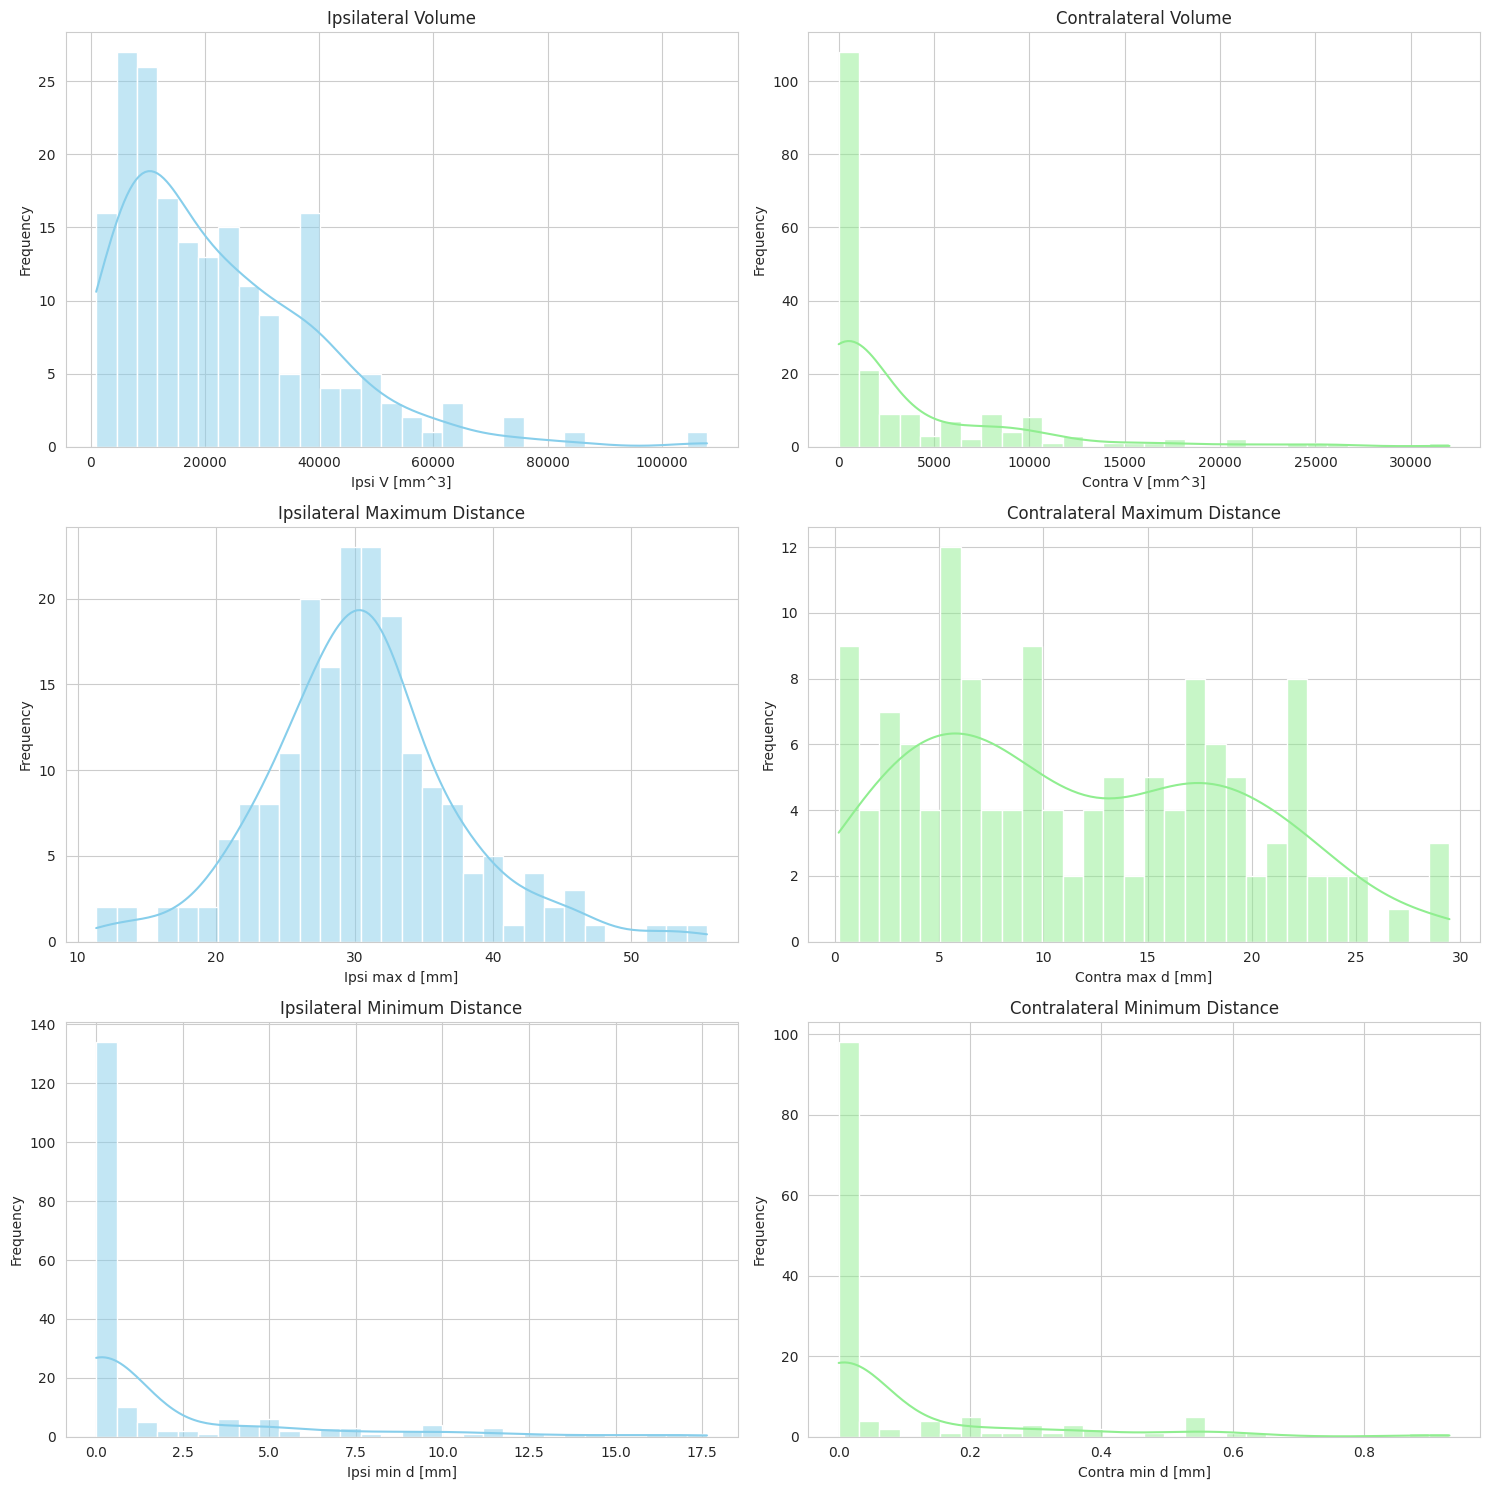

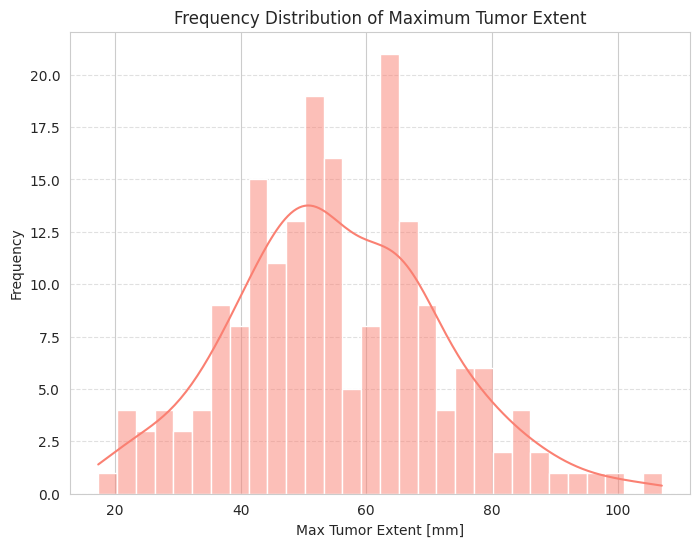

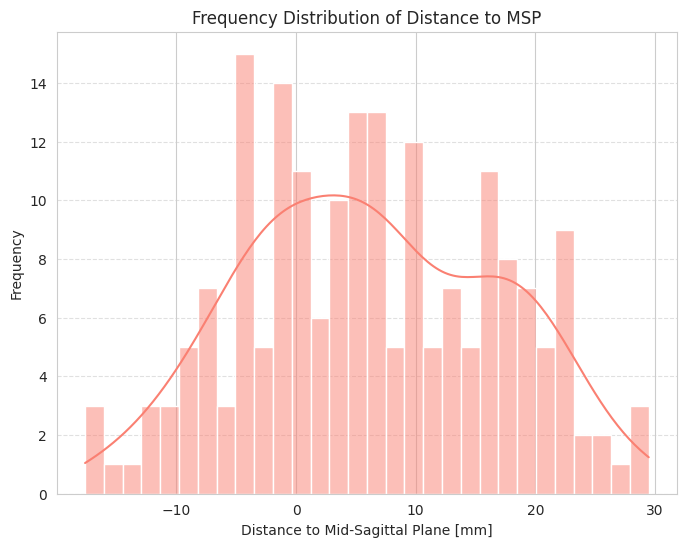

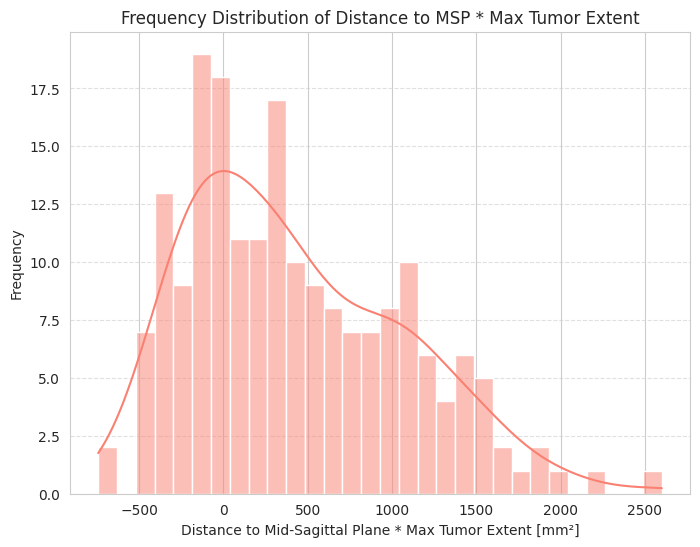

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the clinical properties CSV.
csv_path = "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv"
df = pd.read_csv(csv_path)

# Increase the style settings for Seaborn
sns.set_style("whitegrid")

# -------------------------------
# Create frequency distribution plots for side-specific properties
# -------------------------------

# Define the properties for ipsi and contralateral sides
properties = {
    "Volume": {"ipsi": "Ipsi V [mm^3]", "contra": "Contra V [mm^3]"},
    "Maximum Distance": {"ipsi": "Ipsi max d [mm]", "contra": "Contra max d [mm]"},
    "Minimum Distance": {"ipsi": "Ipsi min d [mm]", "contra": "Contra min d [mm]"}
}

# Create a 3x2 grid of subplots:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Loop over the properties and plot ipsilateral on the left and contralateral on the right.
for i, (prop_name, cols) in enumerate(properties.items()):
    # Ipsilateral plot (left column)
    sns.histplot(data=df, x=cols["ipsi"], kde=True, ax=axes[i, 0], bins=30, color="skyblue")
    axes[i, 0].set_title(f"Ipsilateral {prop_name}")
    axes[i, 0].set_xlabel(cols["ipsi"])
    axes[i, 0].set_ylabel("Frequency")
    
    # Contralateral plot (right column)
    sns.histplot(data=df, x=cols["contra"], kde=True, ax=axes[i, 1], bins=30, color="lightgreen")
    axes[i, 1].set_title(f"Contralateral {prop_name}")
    axes[i, 1].set_xlabel(cols["contra"])
    axes[i, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# -------------------------------
# Create frequency distribution plot for Maximum Tumor Extent (overall)
# -------------------------------
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="Max Tumor Extent [mm]", kde=True, bins=30, color="salmon")
plt.xlabel("Max Tumor Extent [mm]")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Maximum Tumor Extent")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()
# -------------------------------
# Create frequency distribution for contra max d - ispi min d
# -------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is already loaded
# 1) Ensure numeric
df["Contra max d [mm]"] = pd.to_numeric(df["Contra max d [mm]"], errors="coerce").fillna(0)
df["Ipsi min d [mm]"]   = pd.to_numeric(df["Ipsi min d [mm]"], errors="coerce").fillna(0)

# 2) Compute diff
df["diff_msp"] = df["Contra max d [mm]"] - df["Ipsi min d [mm]"]

# 3) Plot
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df,
    x="diff_msp",
    kde=True,
    bins=30,
    
    color="salmon"
)
plt.xlabel("Distance to Mid-Sagittal Plane [mm]")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Distance to MSP")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# -------------------------------
# Create frequency distribution of diff_msp * max tumor extent  
# -------------------------------


df["diff_msp_max_tumor_extent"] = df["diff_msp"] * df["Max Tumor Extent [mm]"]
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df,
    x="diff_msp_max_tumor_extent",
    kde=True,
    bins=30,
    color="salmon"
)
plt.xlabel("Distance to Mid-Sagittal Plane * Max Tumor Extent [mm²]")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Distance to MSP * Max Tumor Extent")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
# -------------------------------


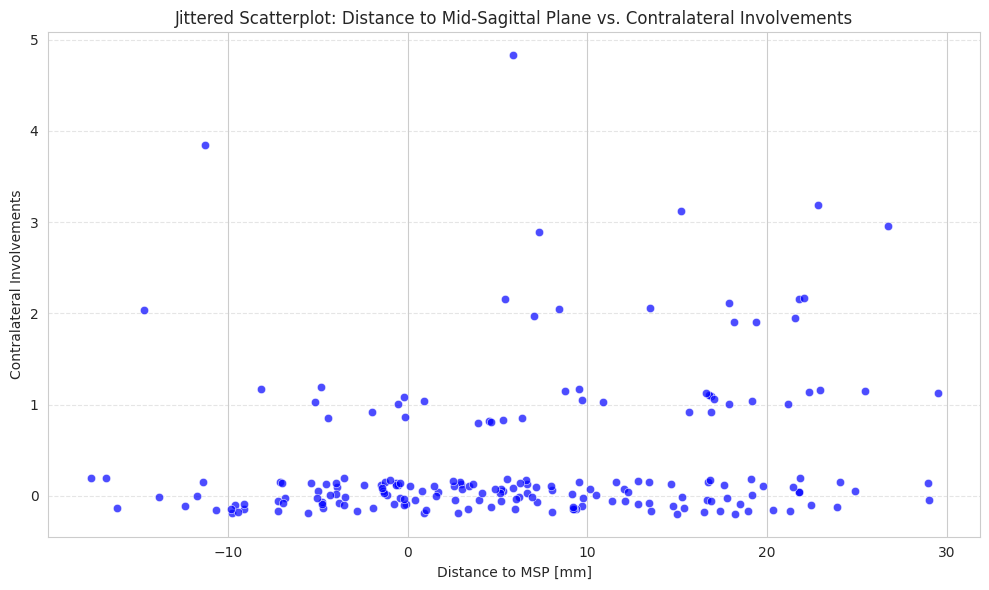

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ——————————————
# 1. Load & Prepare Data
# ——————————————
csv_path = "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv"
df = pd.read_csv(csv_path)
df["Ipsi min d [mm]"]   = pd.to_numeric(df["Ipsi min d [mm]"],   errors="coerce").fillna(0)
df["Contra max d [mm]"] = pd.to_numeric(df["Contra max d [mm]"], errors="coerce").fillna(0)
df["diff"] = df["Contra max d [mm]"] - df["Ipsi min d [mm]"]
df["contralateral involvements"] = (
    pd.to_numeric(df["contralateral involvements"], errors="coerce")
      .fillna(0).astype(int)
)

# ——————————————
# 2. Plot with true vertical jitter
# ——————————————
plt.figure(figsize=(10, 6))

# compute a tiny vertical offset for each point
y = df["contralateral involvements"].values
y_jitter = y + np.random.uniform(-0.2, 0.2, size=len(df))

plt.scatter(
    df["diff"],
    y_jitter,
    alpha=0.7,
    color="blue",
    edgecolor="w",
    linewidth=0.5
)
plt.xlabel("Distance to MSP [mm]")
plt.ylabel("Contralateral Involvements")
plt.title("Jittered Scatterplot: Distance to Mid-Sagittal Plane vs. Contralateral Involvements")
plt.yticks(sorted(df["contralateral involvements"].unique()))
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


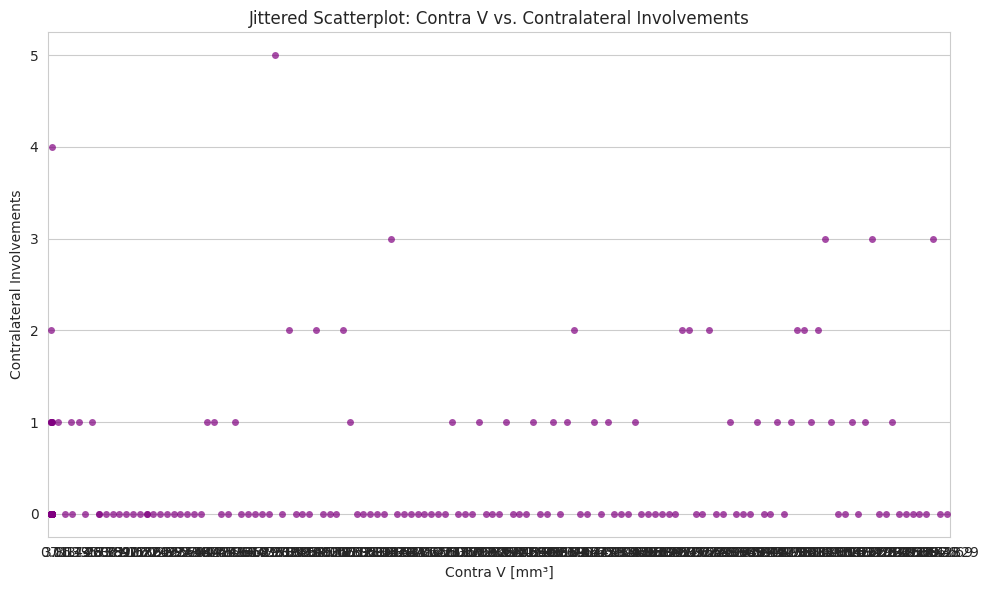

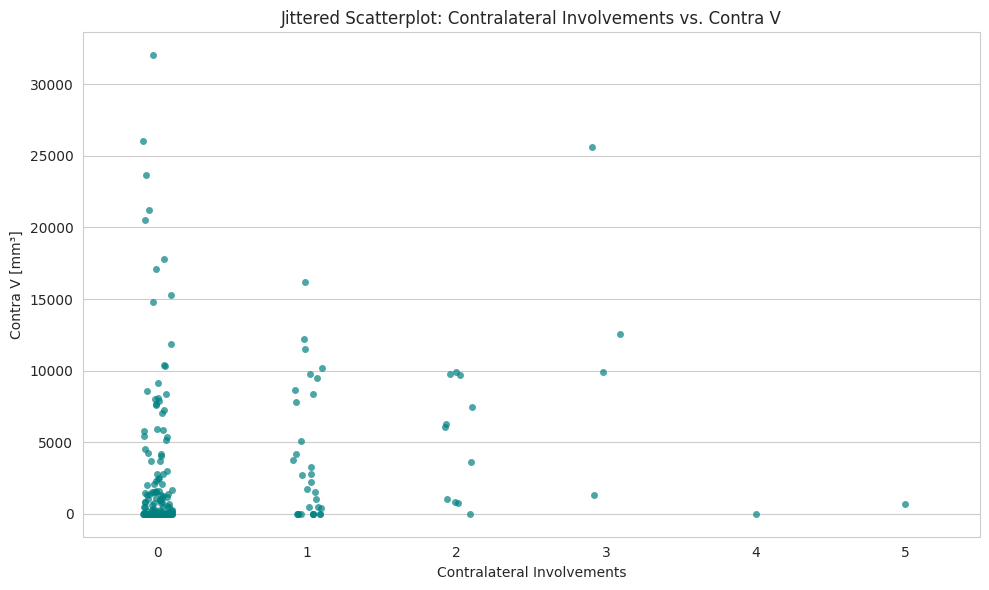

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Data Preparation
# -------------------------------

# Load the imaging properties CSV.
csv_path = (
    "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/"
    "Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/"
    "gtv_properties.csv"
)
df = pd.read_csv(csv_path)

# Convert Contra V to numeric, filling non‑numeric with 0.
df["Contra V [mm^3]"] = pd.to_numeric(df["Contra V [mm^3]"], errors="coerce").fillna(0)

# Ensure contralateral involvements is integer.
df["contralateral involvements"] = (
    pd.to_numeric(df["contralateral involvements"], errors="coerce")
    .fillna(0)
    .astype(int)
)

# Optional: set Seaborn style.
sns.set_style("whitegrid")

# -------------------------------
# Plot A: Jittered Scatterplot
#         x = Contra V, y = involvements
# -------------------------------
plt.figure(figsize=(10, 6))
ax1 = sns.stripplot(
    x="Contra V [mm^3]",
    y="contralateral involvements",
    data=df,
    jitter=True,
    alpha=0.7,
    color="purple"
)
ax1.set_xlabel("Contra V [mm³]")
ax1.set_ylabel("Contralateral Involvements")
ax1.set_title("Jittered Scatterplot: Contra V vs. Contralateral Involvements")

# Optionally show only 5 evenly spaced x‑ticks
min_v = df["Contra V [mm^3]"].min()
max_v = df["Contra V [mm^3]"].max()

plt.tight_layout()
plt.show()

# -------------------------------
# Plot B: Jittered Scatterplot
#         x = involvements, y = Contra V
# -------------------------------
plt.figure(figsize=(10, 6))
ax2 = sns.stripplot(
    x="contralateral involvements",
    y="Contra V [mm^3]",
    data=df,
    jitter=True,
    alpha=0.7,
    color="teal"
)
ax2.set_xlabel("Contralateral Involvements")
ax2.set_ylabel("Contra V [mm³]")
ax2.set_title("Jittered Scatterplot: Contralateral Involvements vs. Contra V")

# x-axis ticks for discrete involvement counts
unique_counts = sorted(df["contralateral involvements"].unique())
ax2.set_xticks(unique_counts)
ax2.set_xticklabels(unique_counts)

plt.tight_layout()
plt.show()


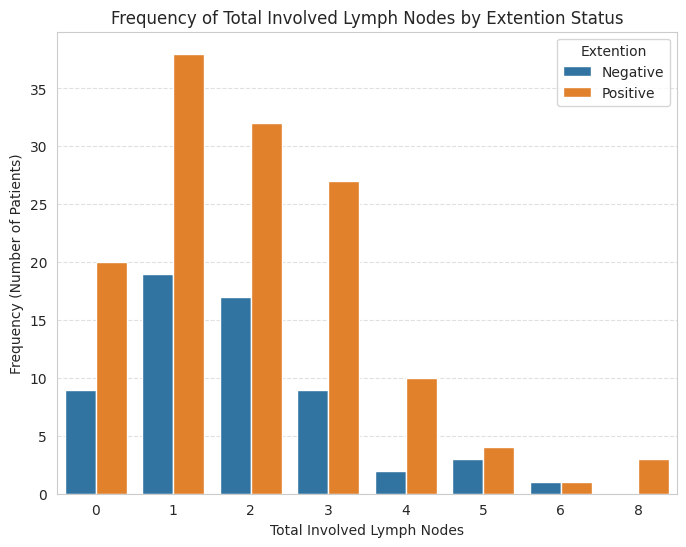

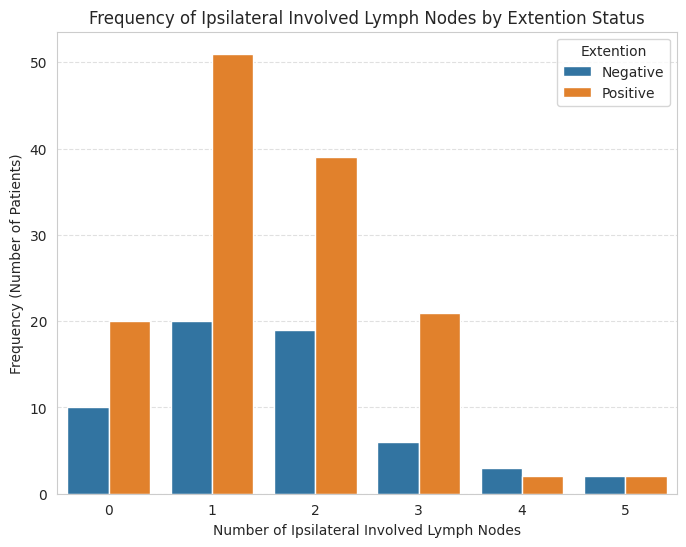

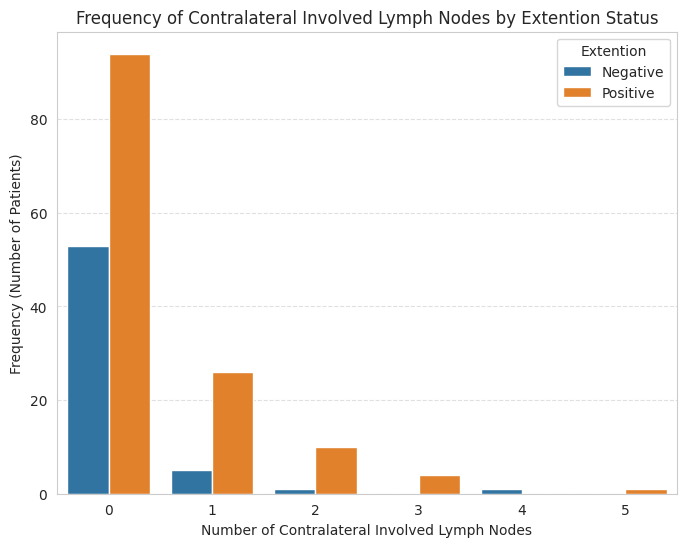

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV containing all properties.
# The CSV is assumed to contain (among others) the following columns:
# "Extention", "ipsilateral involvements", "contralateral involvements", and "Patient"
df = pd.read_csv("/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv")

# Convert the "Extention" column to lowercase strings to standardize the values ("positive" or "negative")
df['Extention'] = df['Extention'].str.strip().str.lower()

# Compute the total number of involved lymph nodes per patient 
df["total_involvements"] = df["ipsilateral involvements"] + df["contralateral involvements"]

# Create a grouped bar plot: at each x (total involved nodes) there are two bars, one for "positive"
# and one for "negative" extention.
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="total_involvements", hue="Extention", hue_order=["negative", "positive"])

plt.xlabel("Total Involved Lymph Nodes")
plt.ylabel("Frequency (Number of Patients)")
plt.title("Frequency of Total Involved Lymph Nodes by Extention Status")
plt.legend(title="Extention", labels=["Negative", "Positive"])
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()



plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="ipsilateral involvements", hue="Extention", hue_order=["negative", "positive"])
plt.xlabel("Number of Ipsilateral Involved Lymph Nodes")
plt.ylabel("Frequency (Number of Patients)")
plt.title("Frequency of Ipsilateral Involved Lymph Nodes by Extention Status")
plt.legend(title="Extention", labels=["Negative", "Positive"])
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()

# -------------------------------
# Plot 2: Contralateral Involvements by Extention Status
# -------------------------------

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="contralateral involvements", hue="Extention", hue_order=["negative", "positive"])
plt.xlabel("Number of Contralateral Involved Lymph Nodes")
plt.ylabel("Frequency (Number of Patients)")
plt.title("Frequency of Contralateral Involved Lymph Nodes by Extention Status")
plt.legend(title="Extention", labels=["Negative", "Positive"])
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()



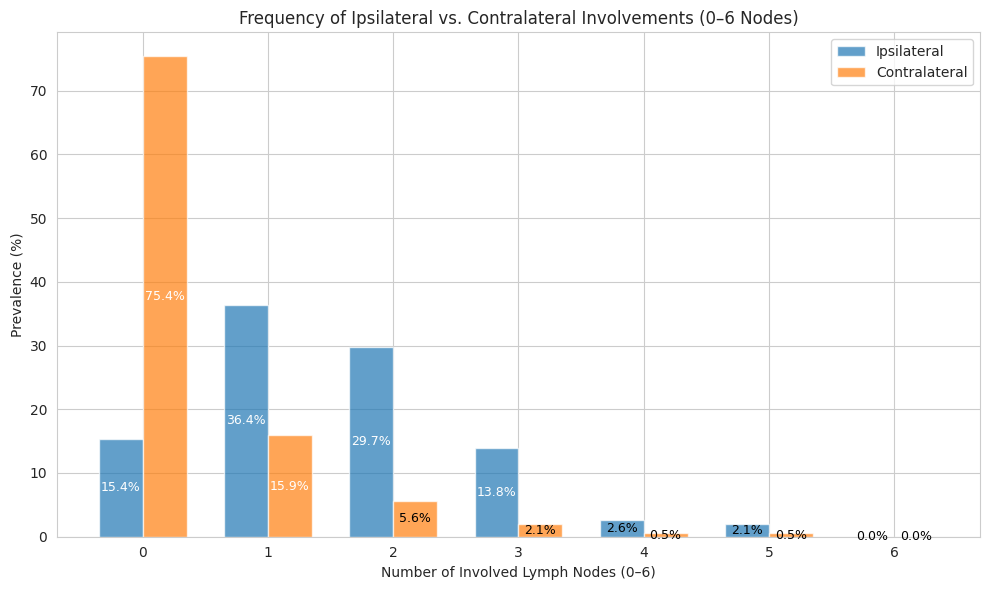

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load data ---
csv_path = "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv"
df = pd.read_csv(csv_path)

# --- 2. Ensure the involvement counts are numeric ---
df["ipsilateral involvements"]   = pd.to_numeric(df["ipsilateral involvements"], errors="coerce").fillna(0).astype(int)
df["contralateral involvements"] = pd.to_numeric(df["contralateral involvements"], errors="coerce").fillna(0).astype(int)

# --- 3. Compute percentages for counts 0 through 6 ---
total_ipsi = len(df)
bins = range(0, 7)  # 0 to 6
counts_ipsi   = df["ipsilateral involvements"].value_counts().reindex(bins, fill_value=0)
counts_contra = df["contralateral involvements"].value_counts().reindex(bins, fill_value=0)

pct_ipsi   = counts_ipsi   / total_ipsi * 100
pct_contra = counts_contra / total_ipsi * 100

# --- 4. Plot side‑by‑side bar chart including zero ---
sns.set_style("whitegrid")
x = np.arange(0, 7)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars_ipsi   = ax.bar(x - width/2, pct_ipsi,   width, label="Ipsilateral",   alpha=0.7)
bars_contra = ax.bar(x + width/2, pct_contra, width, label="Contralateral", alpha=0.7)

# annotate inside bars
for bars in (bars_ipsi, bars_contra):
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h/2,
            f"{h:.1f}%",
            ha="center",
            va="center",
            color="white" if h > 10 else "black",
            fontsize=9
        )

ax.set_xticks(x)
ax.set_xlabel("Number of Involved Lymph Nodes (0–6)")
ax.set_ylabel("Prevalence (%)")
ax.set_title("Frequency of Ipsilateral vs. Contralateral Involvements (0–6 Nodes)")
ax.legend()
plt.tight_layout()
plt.show()


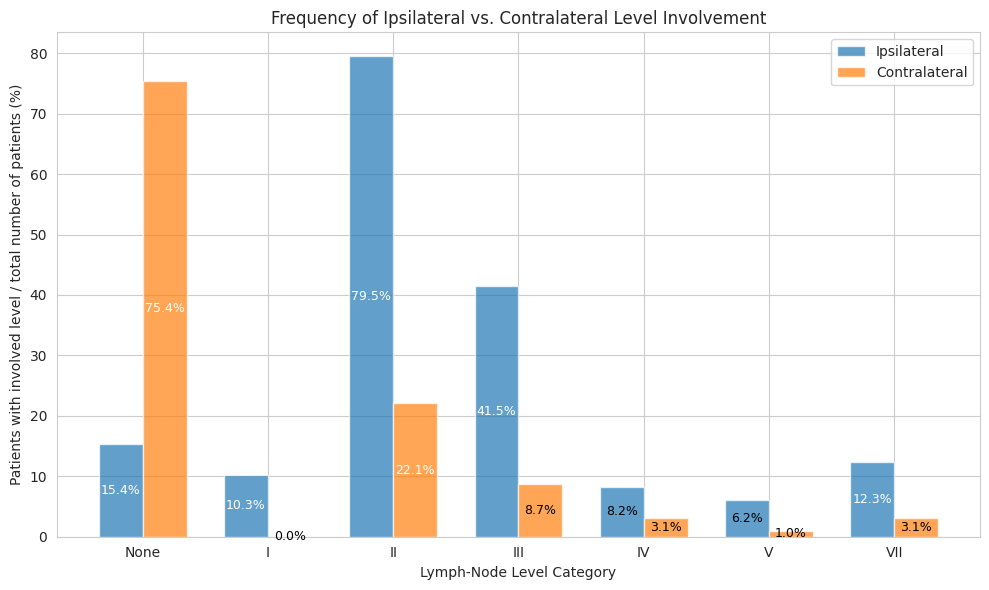

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# -------------------------------
# 1. Parse lymph‑node involvement CSV
# -------------------------------
def parse_lymphnode_csv(file_path):
    allowed = ["I","II","III","IV","V","VII"]
    with open(file_path, newline="") as f:
        rows = list(csv.reader(f))
    header, side_row, lvl_row = rows[0], rows[1], rows[2]
    data_rows = rows[3:]
    # find ipsi/contra max_llh columns
    ipsi_cols = {
        i: lvl_row[i].strip()
        for i,col in enumerate(header)
        if col.strip()=="max_llh"
           and side_row[i].strip().lower()=="ipsi"
           and lvl_row[i].strip() in allowed
    }
    contra_cols = {
        i: lvl_row[i].strip()
        for i,col in enumerate(header)
        if col.strip()=="max_llh"
           and side_row[i].strip().lower()=="contra"
           and lvl_row[i].strip() in allowed
    }
    recs = []
    for pid, row in enumerate(data_rows, start=0):
        rec = {"Patient": pid}
        # init flags
        for lvl in allowed:
            rec[f"ipsi_{lvl}"]   = False
            rec[f"contra_{lvl}"] = False
        # fill True/False
        for i,lvl in ipsi_cols.items():
            if row[i].strip().lower()=="true":
                rec[f"ipsi_{lvl}"] = True
        for i,lvl in contra_cols.items():
            if row[i].strip().lower()=="true":
                rec[f"contra_{lvl}"] = True
        recs.append(rec)
    return pd.DataFrame(recs)

ln_df = parse_lymphnode_csv("/home/loriskeller/Documents/Master Project/usz_reduced.csv")

# -------------------------------
# 2. Load imaging properties & merge
# -------------------------------
prop_csv = (
    "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/"
    "Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/"
    "gtv_properties.csv"
)
prop = pd.read_csv(prop_csv)
df = prop.merge(ln_df, on="Patient", how="left")

# -------------------------------
# 3. Compute percentages for each category
# -------------------------------
levels = ["None","I","II","III","IV","V","VII"]
total = len(df)

def compute_pct(side):
    pct = {}
    # None = no involvement at any level
    flags = np.column_stack([df[f"{side}_{lvl}"].fillna(False).values for lvl in levels[1:]])
    none_mask = ~flags.any(axis=1)
    pct["None"] = none_mask.sum()/total*100
    # each level
    for lvl in levels[1:]:
        pct[lvl] = df[f"{side}_{lvl}"].fillna(False).sum()/total*100
    return pct

pct_ipsi   = compute_pct("ipsi")
pct_contra = compute_pct("contra")

# -------------------------------
# 4. Plot side‑by‑side bar chart
# -------------------------------
sns.set_style("whitegrid")
x = np.arange(len(levels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars_ipsi   = ax.bar(x - width/2, [pct_ipsi[l] for l in levels],   width, label="Ipsilateral",   alpha=0.7)
bars_contra = ax.bar(x + width/2, [pct_contra[l] for l in levels], width, label="Contralateral", alpha=0.7)

# annotate inside bars
for bars in (bars_ipsi, bars_contra):
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h/2,
            f"{h:.1f}%",
            ha="center",
            va="center",
            color="white" if h>10 else "black",
            fontsize=9
        )

ax.set_xticks(x)
ax.set_xticklabels(levels)
ax.set_xlabel("Lymph‑Node Level Category")
ax.set_ylabel("Patients with involved level / total number of patients (%)")
ax.set_title("Frequency of Ipsilateral vs. Contralateral Level Involvement")
ax.legend()
plt.tight_layout()
plt.show()


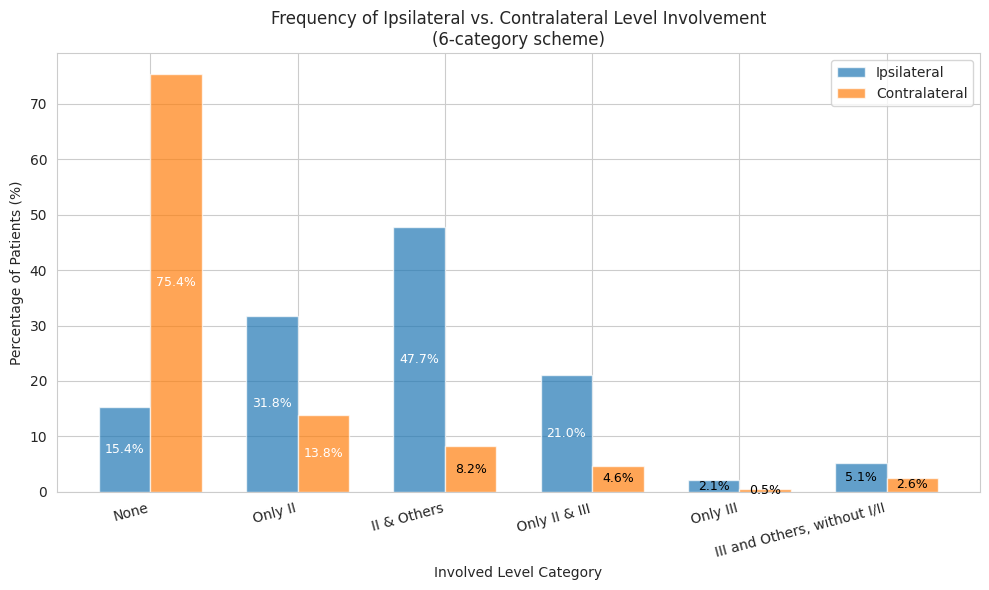

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# -------------------------------
# 1. Parse lymph-node involvement CSV
# -------------------------------
def parse_lymphnode_csv(file_path):
    allowed = ["I","II","III","IV","V","VII"]
    with open(file_path, newline="") as f:
        rows = list(csv.reader(f))
    header, side_row, lvl_row = rows[0], rows[1], rows[2]
    data_rows = rows[3:]
    ipsi_cols = {
        i: lvl_row[i].strip()
        for i,col in enumerate(header)
        if col.strip()=="max_llh"
           and side_row[i].strip().lower()=="ipsi"
           and lvl_row[i].strip() in allowed
    }
    contra_cols = {
        i: lvl_row[i].strip()
        for i,col in enumerate(header)
        if col.strip()=="max_llh"
           and side_row[i].strip().lower()=="contra"
           and lvl_row[i].strip() in allowed
    }
    recs = []
    for pid, row in enumerate(data_rows, start=0):
        rec = {"Patient": pid}
        for lvl in allowed:
            rec[f"ipsi_{lvl}"]   = False
            rec[f"contra_{lvl}"] = False
        for i,lvl in ipsi_cols.items():
            if row[i].strip().lower()=="true":
                rec[f"ipsi_{lvl}"] = True
        for i,lvl in contra_cols.items():
            if row[i].strip().lower()=="true":
                rec[f"contra_{lvl}"] = True
        recs.append(rec)
    return pd.DataFrame(recs)

# File paths
properties_csv = "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv"
usz_reduced_csv = "/home/loriskeller/Documents/Master Project/usz_reduced.csv"

# Parse & merge
ln_df = parse_lymphnode_csv(usz_reduced_csv)
prop  = pd.read_csv(properties_csv)
df    = prop.merge(ln_df, on="Patient", how="left").fillna(False)

# -------------------------------
# 2. Compute 6-category percentages
# -------------------------------
levels = ["I","II","III","IV","V","VII"]
total  = len(df)

def compute_six(side):
    flags = {lvl: df[f"{side}_{lvl}"].astype(bool) for lvl in levels}
    any_flag = np.logical_or.reduce([flags[l] for l in levels])

    # 1) No level involved
    none_pct = (~any_flag).sum() / total * 100

    # 2) Only II involved
    only_ii = flags["II"] & ~np.logical_or.reduce([flags[l] for l in levels if l!="II"])
    only_ii_pct = only_ii.sum() / total * 100

    # 3) II and others (I,III,IV,V,VII)
    ii_and_others = flags["II"] & np.logical_or.reduce([flags[l] for l in levels if l!="II"])
    ii_and_others_pct = ii_and_others.sum() / total * 100

    # 4) Only II and III
    only_ii_iii = flags["II"] & flags["III"] & ~np.logical_or.reduce([flags[l] for l in levels if l not in ("II","III")])
    only_ii_iii_pct = only_ii_iii.sum() / total * 100

    # 5) Only III
    only_iii = flags["III"] & ~np.logical_or.reduce([flags[l] for l in levels if l!="III"])
    only_iii_pct = only_iii.sum() / total * 100

    # 6) III or more without II and I
    ge3_no2no1 = (~flags["I"] & ~flags["II"]) & np.logical_or.reduce([flags[l] for l in ["III","IV","V","VII"]])
    ge3_no2no1_pct = ge3_no2no1.sum() / total * 100

    return [
        none_pct,
        only_ii_pct,
        ii_and_others_pct,
        only_ii_iii_pct,
        only_iii_pct,
        ge3_no2no1_pct
    ]

pct_ipsi   = compute_six("ipsi")
pct_contra = compute_six("contra")

cats = [
    "None",
    "Only II",
    "II & Others",
    "Only II & III",
    "Only III",
    "III and Others, without I/II"
]

# -------------------------------
# 3. Plot side-by-side bar chart
# -------------------------------
sns.set_style("whitegrid")
x = np.arange(len(cats))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars_ipsi   = ax.bar(x - width/2, pct_ipsi,   width, label="Ipsilateral",   alpha=0.7)
bars_contra = ax.bar(x + width/2, pct_contra, width, label="Contralateral", alpha=0.7)

# Annotate bars
for bars in (bars_ipsi, bars_contra):
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h/2,
            f"{h:.1f}%",
            ha="center",
            va="center",
            color="white" if h>10 else "black",
            fontsize=9
        )

ax.set_xticks(x)
ax.set_xticklabels(cats, rotation=15, ha="right")
ax.set_xlabel("Involved Level Category")
ax.set_ylabel("Percentage of Patients (%)")
ax.set_title("Frequency of Ipsilateral vs. Contralateral Level Involvement\n(6-category scheme)")
ax.legend()
plt.tight_layout()
plt.show()


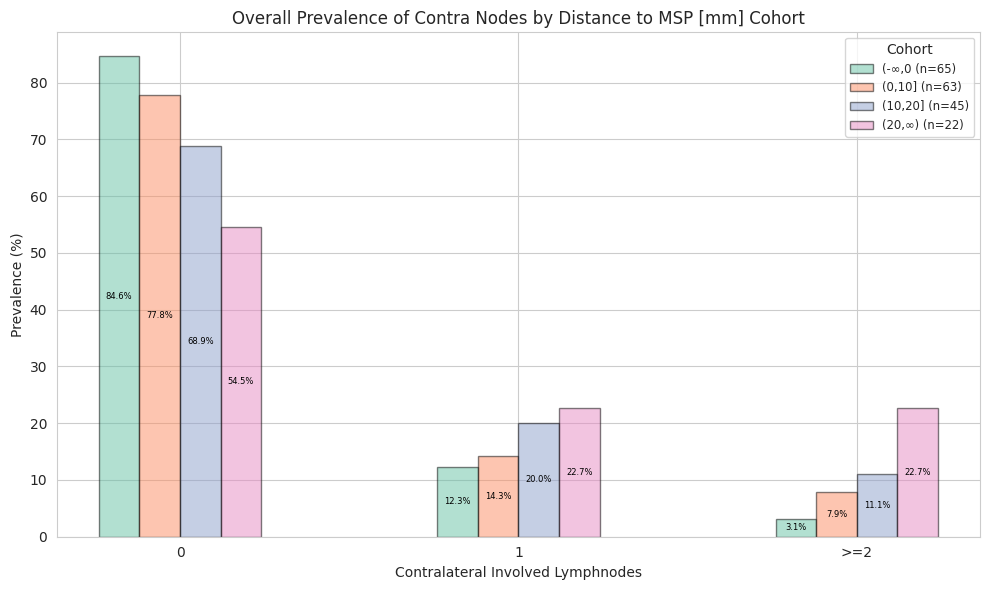

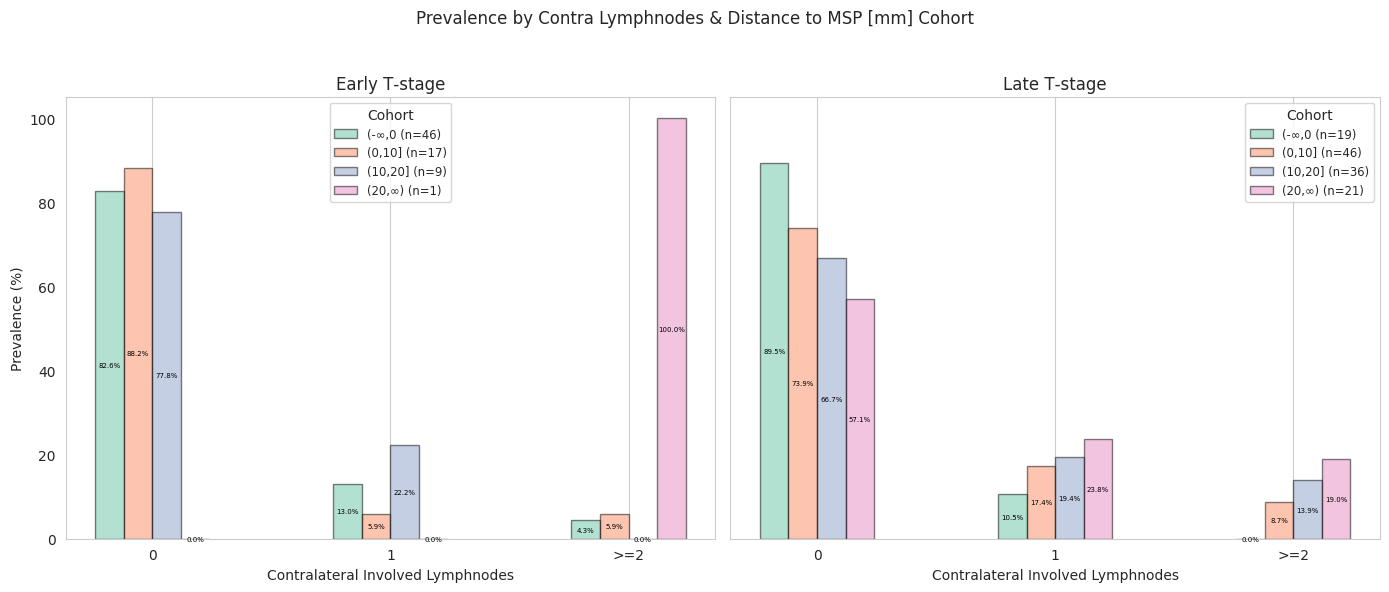

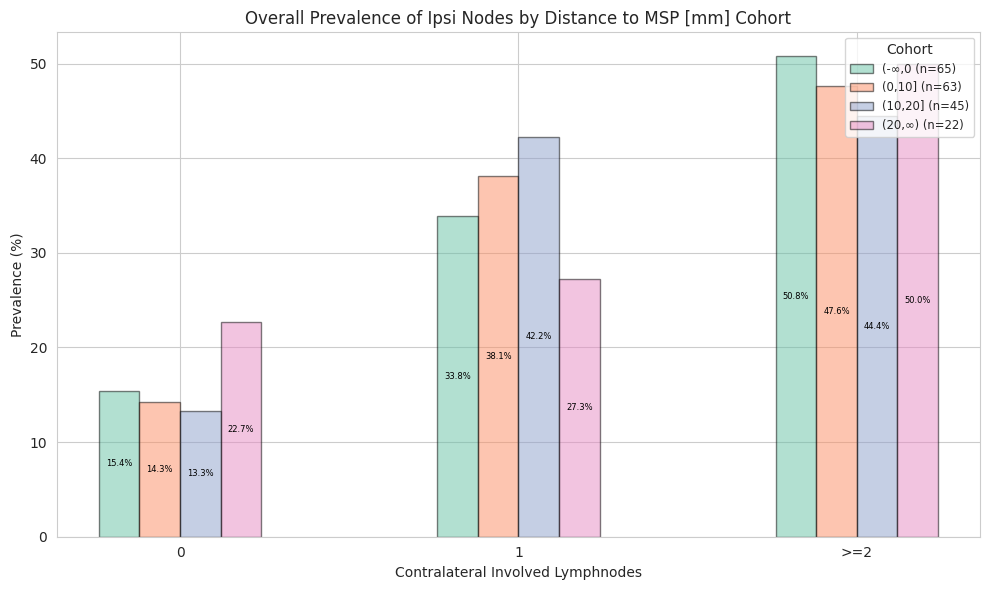

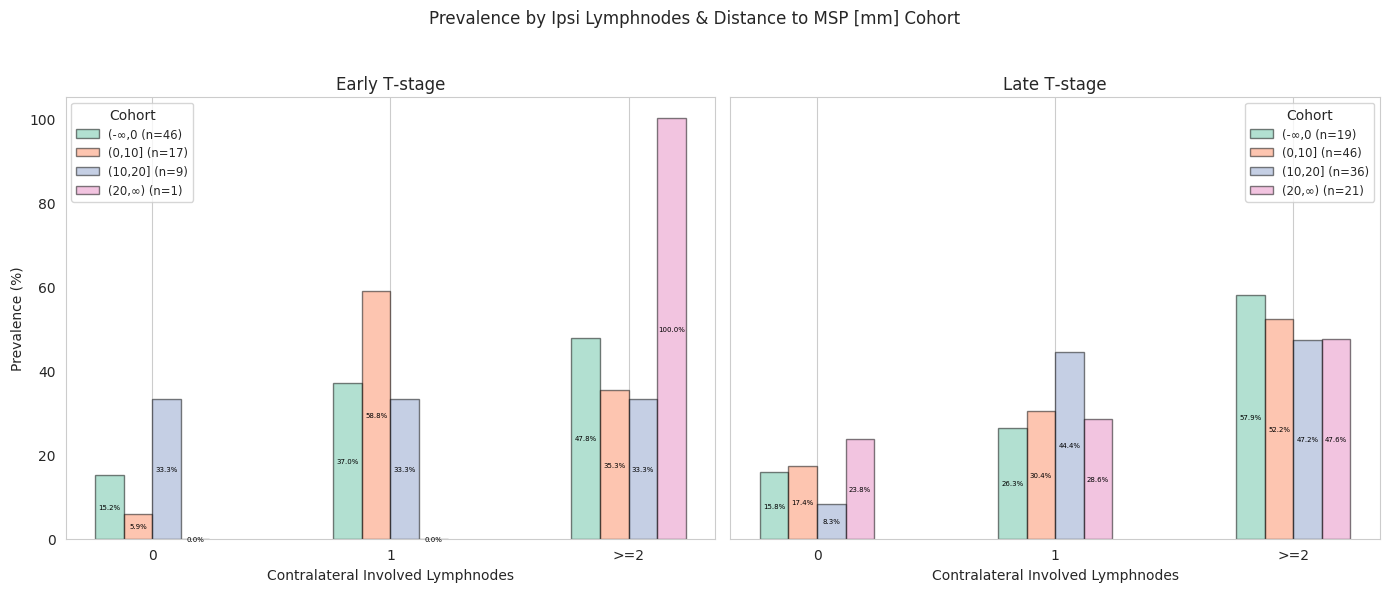

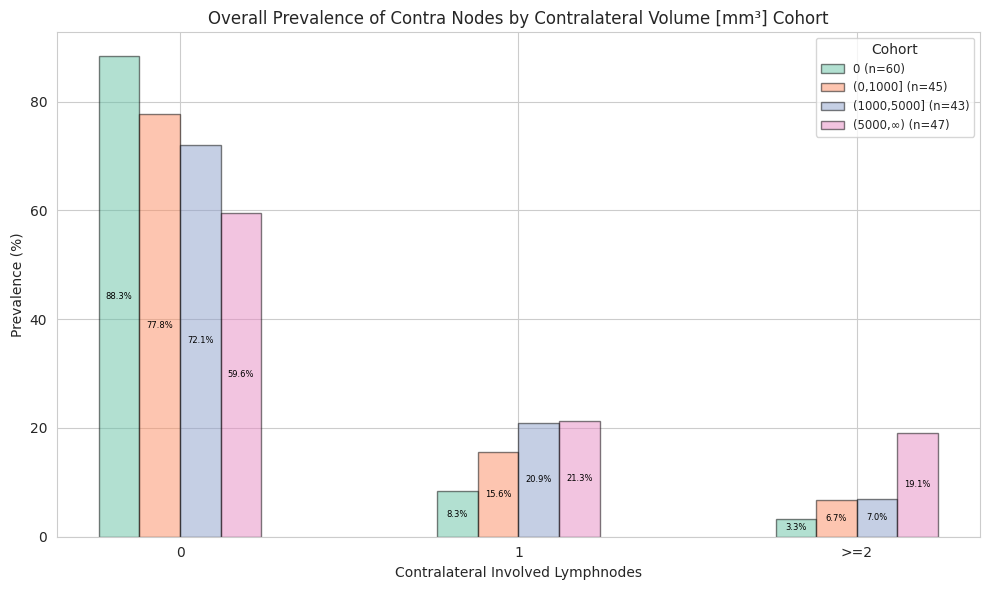

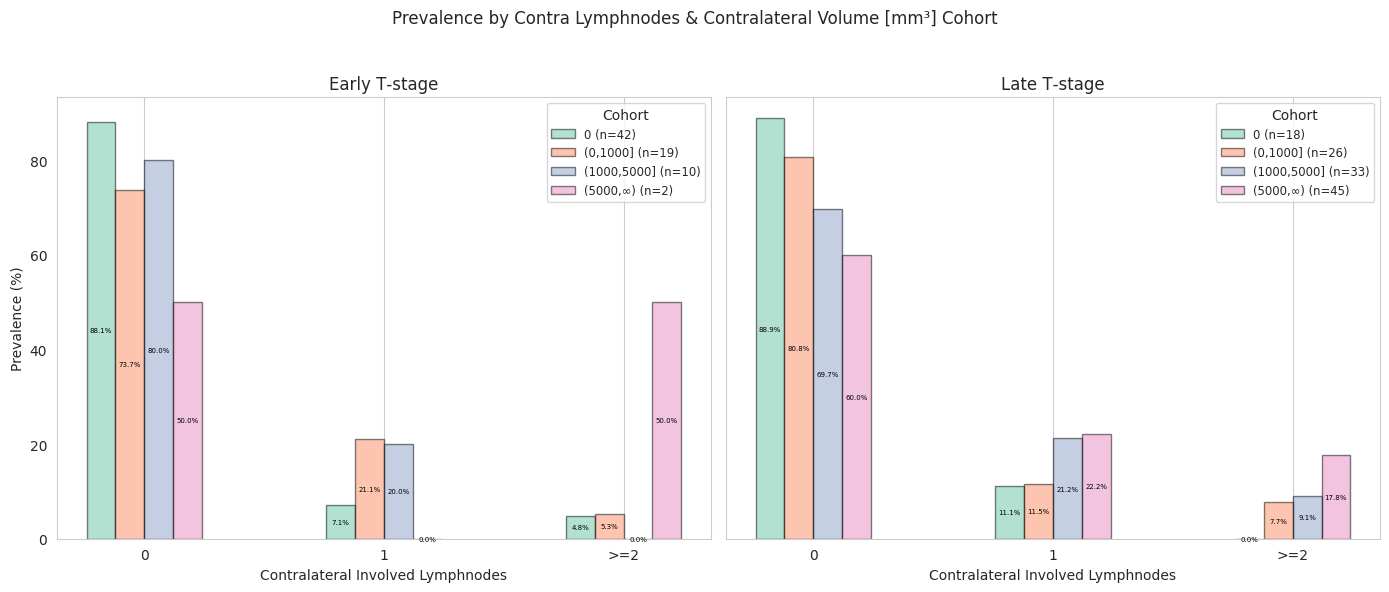

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_prevalence_by_cohort(
    properties_csv: str,
    tstage_csv: str,
    property_col: str,
    bins: list,
    bin_labels: list,
    ipsi: bool = False
):
    """
    Plot prevalence of contralateral involvements by cohorts of a chosen property,
    both overall and split by early vs late T‑stage.

    Parameters:
    -----------
    properties_csv : str
        Path to the imaging properties CSV.
    tstage_csv     : str
        Path to the clinical CSV with T‑stage (header on row 3).
    property_col   : str
        Either "distance" (to compute Contra max d - Ipsi min d) or the exact
        column name for a volume property in the properties CSV.
    bins           : list of float
        Boundaries for pd.cut (e.g. [-np.inf,0,20,np.inf]).
    bin_labels     : list of str
        Same length as `bins`−1, labels for each interval.
    ipsi           : bool
        If True, plot ipsilateral involvements; otherwise contralateral.
    """

    # 1) load imaging properties
    df = pd.read_csv(properties_csv)
    xlabel = "Contralateral Involved Lymphnodes"
    # convert numeric columns
    for col in ["Ipsi min d [mm]", "Contra max d [mm]"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

    if property_col == "distance":
        df["prop"] = df["Contra max d [mm]"] - df["Ipsi min d [mm]"]
        cohort_str = "Distance to MSP [mm]"
    
    if property_col == "Contra mean d [mm]":
        # assume it's a mean distance column in mm
        df["prop"] = pd.to_numeric(df[property_col], errors="coerce").fillna(0)
        cohort_str = "Contralateral Mean Distance [mm]"
        
    if property_col == "distance to msp & max tumor extent":
        df["msp"] = df["Contra max d [mm]"] - df["Ipsi min d [mm]"]
        df["prop"] = df["msp"] * df["Max Tumor Extent [mm]"]
        cohort_str = "Distance to MSP * Max Tumor Extent [mm²]"
        
    if property_col == "Contra V [mm^3]":
        # assume it's a volume column in mm^3
        df["prop"] = pd.to_numeric(df[property_col], errors="coerce").fillna(0)
        cohort_str = "Contralateral Volume [mm³]"
        

    # involvement column
    inv_col = "ipsilateral involvements" if ipsi else "contralateral involvements"
    df[inv_col] = (
        pd.to_numeric(df[inv_col], errors="coerce")
          .fillna(0)
          .astype(int)
    )

    # 2) load T‑stage & assign early/late
    clin = pd.read_csv(tstage_csv, skiprows=2)
    clin = clin.iloc[:len(df)]
    df["T-Stage"]    = (
        pd.to_numeric(clin["t_stage"], errors="coerce")
          .fillna(0)
          .astype(int)
    )
    df["stage_group"] = np.where(df["T-Stage"].isin([1,2]), "early", "late")

    # 3) assign cohorts
    df["cohort"] = pd.cut(df["prop"], bins=bins, labels=bin_labels, right=False)

    # 4) prepare prevalence dicts
    allowed_bins = [0, 1, 2]   # 2 = ">=2"
    bin_labels_inv = ["0", "1", ">=2"]

    def compute_prevalence(sub):
        n = len(sub)
        inv = sub[inv_col].clip(upper=2)
        counts = inv.value_counts().reindex(allowed_bins, fill_value=0)
        return (counts / (n if n>0 else 1)) * 100

    # overall
    prevalence_all = {cat: compute_prevalence(df[df["cohort"]==cat]) 
                      for cat in bin_labels}
    n_all = {cat: len(df[df["cohort"]==cat]) for cat in bin_labels}

    # by stage
    prevalence = {sg: {} for sg in ["early","late"]}
    n_stage    = {sg: {} for sg in ["early","late"]}
    for sg in ["early","late"]:
        sub = df[df["stage_group"]==sg]
        for cat in bin_labels:
            cohort = sub[sub["cohort"]==cat]
            n_stage[sg][cat] = len(cohort)
            prevalence[sg][cat] = compute_prevalence(cohort)

    # 5) plotting
    sns.set_style("whitegrid")
    x = np.arange(len(allowed_bins))
    width = 0.12
    offsets = np.linspace(-((len(bin_labels)-1)/2)*width,
                           ((len(bin_labels)-1)/2)*width,
                           len(bin_labels))
    colors = sns.color_palette("Set2", n_colors=len(bin_labels))

    # overall chart
    fig, ax = plt.subplots(figsize=(10,6))
    for i, cat in enumerate(bin_labels):
        vals = prevalence_all[cat].values
        bars = ax.bar(
            x + offsets[i],
            vals,
            width=width,
            color=colors[i],
            alpha=0.5,
            edgecolor="black",
            label=f"{cat} (n={n_all[cat]})"
        )
        for bar,h in zip(bars,vals):
            ax.text(bar.get_x()+bar.get_width()/2, h/2,
                    f"{h:.1f}%", ha="center", va="center",
                    color="black",
                    fontsize=6)
    ax.set_xticks(x)
    ax.set_xticklabels(bin_labels_inv)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Prevalence (%)")
    ax.set_title(f"Overall Prevalence of {'Ipsi' if ipsi else 'Contra'} Nodes by {cohort_str} Cohort")
    ax.legend(title="Cohort", loc="upper right", fontsize="small")
    plt.tight_layout()
    plt.show()

    # early vs late
    fig, axes = plt.subplots(1,2,figsize=(14,6),sharey=True)
    for ax, sg in zip(axes, ["early","late"]):
        for i, cat in enumerate(bin_labels):
            vals = prevalence[sg][cat].values
            bars = ax.bar(
                x + offsets[i],
                vals,
                width=width,
                color=colors[i],
                alpha=0.5,
                edgecolor="black",
                label=f"{cat} (n={n_stage[sg][cat]})"
            )
            for bar,h in zip(bars,vals):
                ax.text(bar.get_x()+bar.get_width()/2, h/2,
                        f"{h:.1f}%", ha="center", va="center",
                        color="black",
                        fontsize=5)
        ax.set_xticks(x)
        ax.set_xticklabels(bin_labels_inv)
        ax.set_xlabel("Contralateral Involved Lymphnodes")
        ax.set_title(f"{sg.capitalize()} T‑stage")
        ax.legend(title="Cohort", fontsize="small")
        ax.grid(axis="y")

    axes[0].set_ylabel("Prevalence (%)")
    plt.suptitle(f"Prevalence by {'Ipsi' if ipsi else 'Contra'} Lymphnodes & {cohort_str} Cohort")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

properties_csv = properties_csv = "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv"
usz_reduced_csv = "/home/loriskeller/Documents/Master Project/usz_reduced.csv"

plot_prevalence_by_cohort(
    properties_csv=properties_csv,
    tstage_csv=usz_reduced_csv,
    property_col="distance",
    bins=[-np.inf, 0, 10, 20, np.inf],
    bin_labels= ["(-∞,0","(0,10]","(10,20]","(20,∞)"],
    ipsi=False
)
plot_prevalence_by_cohort(
    properties_csv=properties_csv,
    tstage_csv=usz_reduced_csv,
    property_col="distance",
    bins=[-np.inf, 0, 10, 20, np.inf],
    bin_labels= ["(-∞,0","(0,10]","(10,20]","(20,∞)"],
    ipsi=True
)

plot_prevalence_by_cohort(
    properties_csv=properties_csv,
    tstage_csv=usz_reduced_csv,
    property_col="Contra V [mm^3]",
    bins=[-0.1, 0.1, 1000, 5000, np.inf],
    bin_labels=["0","(0,1000]","(1000,5000]","(5000,∞)"],
    ipsi=False
)

# plot_prevalence_by_cohort(
#     properties_csv=properties_csv,
#     tstage_csv=usz_reduced_csv,
#     property_col="Contra mean d [mm]",
#     bins=[-0.1, 0.1, 2.5, 5, np.inf],
#     bin_labels=["0","(0,2.5]","(2.5,5]","(5,∞)"],
#     ipsi=False
# )
# plot_prevalence_by_cohort(
#     properties_csv=properties_csv,
#     tstage_csv=usz_reduced_csv,
#     property_col="distance to msp & max tumor extent",
#     bins=[-np.inf, -100, 200, 500, np.inf],
#     bin_labels=["(-∞,-100]","(-100,200]","(200,500]","(500,∞)"],
#     ipsi=False
# )




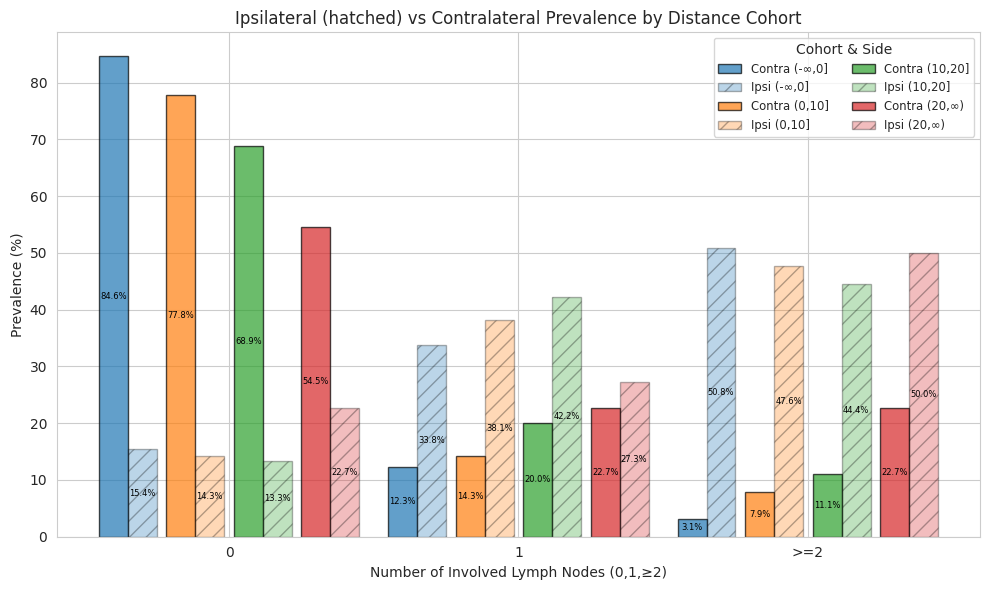

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_prevalence(df, inv_col, cohorts, allowed_bins):
    """
    Given df with a categorical 'cohort' column and an integer involvement column inv_col,
    returns {cohort_label: pd.Series of prevalence [%] indexed by allowed_bins}.
    """
    out = {}
    for cat in cohorts:
        sub = df[df["cohort"] == cat]
        n = len(sub)
        inv = sub[inv_col].clip(upper=allowed_bins[-1])
        counts = inv.value_counts().reindex(allowed_bins, fill_value=0)
        out[cat] = (counts / (n if n>0 else 1)) * 100
    return out

# --- 1) Load & prepare imaging + clinical data
properties_csv = "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv"
tstage_csv     = "/home/loriskeller/Documents/Master Project/usz_reduced.csv"

df = pd.read_csv(properties_csv)
# ensure numeric & compute distance
df["Ipsi min d [mm]"]   = pd.to_numeric(df["Ipsi min d [mm]"],   errors="coerce").fillna(0)
df["Contra max d [mm]"] = pd.to_numeric(df["Contra max d [mm]"], errors="coerce").fillna(0)
df["diff"] = df["Contra max d [mm]"] - df["Ipsi min d [mm]"]

# read T-stage and align
clin = pd.read_csv(tstage_csv, skiprows=2).iloc[:len(df)]
df["T-Stage"]    = pd.to_numeric(clin["t_stage"], errors="coerce").fillna(0).astype(int)
df["stage_group"]= np.where(df["T-Stage"].isin([1,2]), "early", "late")

# contralateral & ipsilateral counts
df["contra_inv"] = pd.to_numeric(df["contralateral involvements"], errors="coerce").fillna(0).astype(int)
df["ipsi_inv"]   = pd.to_numeric(df["ipsilateral involvements"],   errors="coerce").fillna(0).astype(int)

# --- 2) define cohorts
bins       = [-np.inf, 0, 10, 20, np.inf]
coh_labels = ["(-∞,0]", "(0,10]", "(10,20]", "(20,∞)"]
df["cohort"] = pd.cut(df["diff"], bins=bins, labels=coh_labels, right=True)

# involvement categories
allowed_bins    = [0,1,2]          # we'll interpret 2 as ">=2"
inv_tick_labels = ["0","1",">=2"]

# --- 3) compute prevalences
prev_contra = compute_prevalence(df, "contra_inv", coh_labels, allowed_bins)
prev_ipsi   = compute_prevalence(df, "ipsi_inv",   coh_labels, allowed_bins)

# --- 4) plot both in one figure
sns.set_style("whitegrid")
x       = np.arange(len(allowed_bins))
n_coh   = len(coh_labels)
total_w = 0.8
bar_w   = total_w / (2*n_coh)      # half‐width per side
base_offsets = np.linspace(-total_w/2 + bar_w/2,
                            total_w/2 - bar_w/2,
                            n_coh)
colors = sns.color_palette("tab10", n_coh)

plt.figure(figsize=(10,6))

for i, cat in enumerate(coh_labels):
    off = base_offsets[i]

    # Contralateral bars (solid)
    contra_vals = prev_contra[cat].values
    contra_bars = plt.bar(
        x + off - bar_w/2,
        contra_vals,
        width=bar_w,
        color=colors[i],
        alpha=0.7,
        edgecolor="black",
        label=f"Contra {cat}"
    )
    # annotate contralateral
    for bar, h in zip(contra_bars, contra_vals):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h/2,
            f"{h:.1f}%",
            ha="center",
            va="center",
            color="black",
            fontsize=6
        )

    # Ipsilateral bars (hatched)
    ipsi_vals = prev_ipsi[cat].values
    ipsi_bars = plt.bar(
        x + off + bar_w/2,
        ipsi_vals,
        width=bar_w,
        color=colors[i],
        alpha=0.3,
        edgecolor="black",
        hatch='//',
        label=f"Ipsi {cat}"
    )
    # annotate ipsilateral
    for bar, h in zip(ipsi_bars, ipsi_vals):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h/2,
            f"{h:.1f}%",
            ha="center",
            va="center",
            color="black",
            fontsize=6
        )

plt.xticks(x, inv_tick_labels)
plt.xlabel("Number of Involved Lymph Nodes (0,1,≥2)")
plt.ylabel("Prevalence (%)")
plt.title("Ipsilateral (hatched) vs Contralateral Prevalence by Distance Cohort")
plt.legend(ncol=2, fontsize="small", title="Cohort & Side", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()



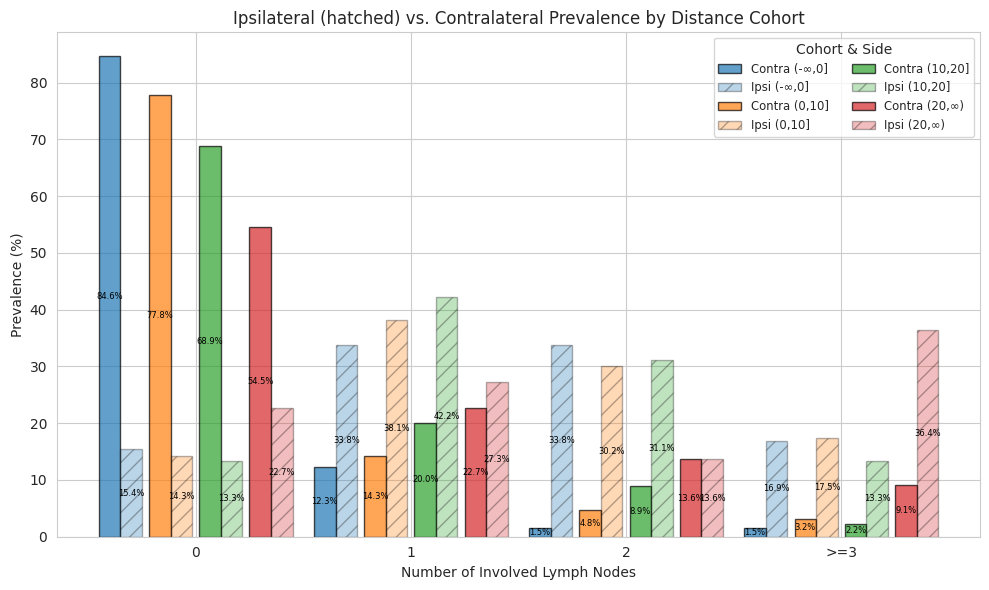

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# --- 1) Load & prepare imaging + clinical data
properties_csv = "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv"
tstage_csv     = "/home/loriskeller/Documents/Master Project/usz_reduced.csv"

df = pd.read_csv(properties_csv)
# ensure numeric & compute distance
df["Ipsi min d [mm]"]   = pd.to_numeric(df["Ipsi min d [mm]"],   errors="coerce").fillna(0)
df["Contra max d [mm]"] = pd.to_numeric(df["Contra max d [mm]"], errors="coerce").fillna(0)
df["diff"] = df["Contra max d [mm]"] - df["Ipsi min d [mm]"]

# read T-stage and align
clin = pd.read_csv(tstage_csv, skiprows=2).iloc[:len(df)]
df["T-Stage"]    = pd.to_numeric(clin["t_stage"], errors="coerce").fillna(0).astype(int)
df["stage_group"]= np.where(df["T-Stage"].isin([1,2]), "early", "late")

# contralateral & ipsilateral counts
df["contra_inv"] = pd.to_numeric(df["contralateral involvements"], errors="coerce").fillna(0).astype(int)
df["ipsi_inv"]   = pd.to_numeric(df["ipsilateral involvements"],   errors="coerce").fillna(0).astype(int)

# --- 2) define cohorts
bins       = [-np.inf, 0, 10, 20, np.inf]
coh_labels = ["(-∞,0]", "(0,10]", "(10,20]", "(20,∞)"]
df["cohort"] = pd.cut(df["diff"], bins=bins, labels=coh_labels, right=True)

coh_labels = ["(-∞,0]","(0,10]","(10,20]","(20,∞)"]
allowed_bins   = [0, 1, 2, 3]      # 3 == ">=3"
inv_tick_labels = ["0","1","2",">=3"]

def compute_prevalence(arr):
    """Given an integer Series, clip at 3 and return % counts for 0,1,2,3."""
    n = len(arr)
    clipped = arr.clip(upper=3)
    counts  = clipped.value_counts().reindex(allowed_bins, fill_value=0)
    return (counts / (n if n>0 else 1) * 100).values

# build prevalence tables
prev_contra = {c: compute_prevalence(df[df["cohort"]==c]["contra_inv"]) for c in coh_labels}
prev_ipsi   = {c: compute_prevalence(df[df["cohort"]==c]["ipsi_inv"])   for c in coh_labels}

# --- plotting ---
sns.set_style("whitegrid")
x       = np.arange(len(allowed_bins))
n_coh   = len(coh_labels)
total_w = 0.8
bar_w   = total_w / (2 * n_coh)
base_offsets = np.linspace(-total_w/2 + bar_w/2,
                             total_w/2 - bar_w/2,
                             n_coh)
colors = sns.color_palette("tab10", n_coh)

plt.figure(figsize=(10,6))

for i, cat in enumerate(coh_labels):
    off = base_offsets[i]

    # Contralateral (solid)
    contra_vals = prev_contra[cat]
    contra_bars = plt.bar(
        x + off - bar_w/2,
        contra_vals,
        width=bar_w,
        color=colors[i],
        alpha=0.7,
        edgecolor="black",
        label=f"Contra {cat}"
    )
    for bar, h in zip(contra_bars, contra_vals):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h/2,
            f"{h:.1f}%",
            ha="center",
            va="center",
            color="black",
            fontsize=6
        )

    # Ipsilateral (hatched)
    ipsi_vals = prev_ipsi[cat]
    ipsi_bars = plt.bar(
        x + off + bar_w/2,
        ipsi_vals,
        width=bar_w,
        color=colors[i],
        alpha=0.3,
        edgecolor="black",
        hatch='//',
        label=f"Ipsi {cat}"
    )
    for bar, h in zip(ipsi_bars, ipsi_vals):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h/2,
            f"{h:.1f}%",
            ha="center",
            va="center",
            color="black",
            fontsize=6
        )

plt.xticks(x, inv_tick_labels)
plt.xlabel("Number of Involved Lymph Nodes")
plt.ylabel("Prevalence (%)")
plt.title("Ipsilateral (hatched) vs. Contralateral Prevalence by Distance Cohort")
plt.legend(ncol=2, fontsize="small", title="Cohort & Side", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


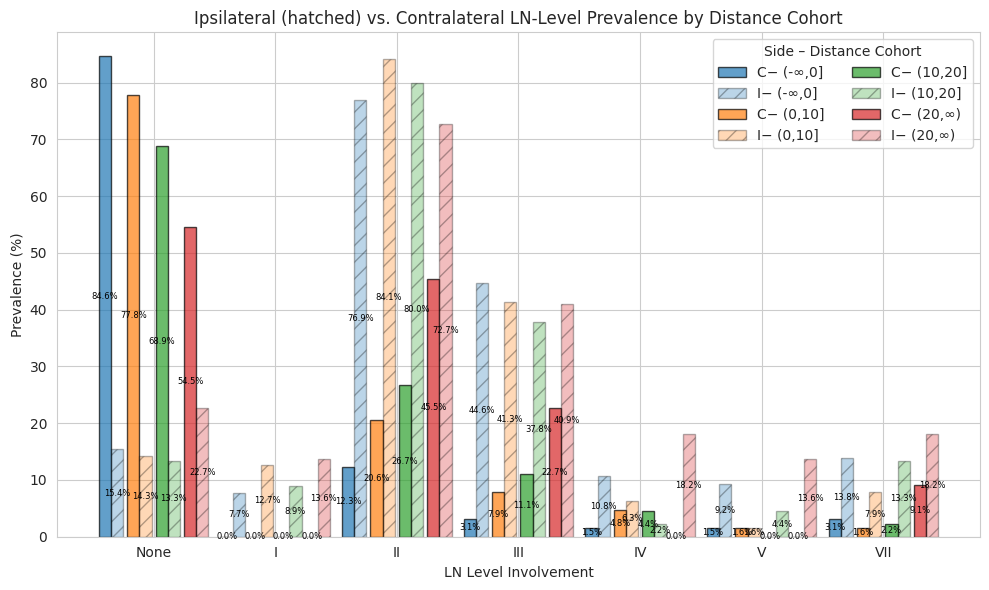

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# --------------------------------
# 1) Parse lymph-node involvement CSV
# --------------------------------
def parse_lymphnode_csv(file_path):
    allowed = ["I","II","III","IV","V","VII"]
    with open(file_path, newline="") as f:
        rows = list(csv.reader(f))
    header, side_row, lvl_row = rows[0], rows[1], rows[2]
    data_rows = rows[3:]
    ipsi_cols = {
        i: lvl_row[i]
        for i,col in enumerate(header)
        if col=="max_llh" and side_row[i].lower()=="ipsi" and lvl_row[i] in allowed
    }
    contra_cols = {
        i: lvl_row[i]
        for i,col in enumerate(header)
        if col=="max_llh" and side_row[i].lower()=="contra" and lvl_row[i] in allowed
    }
    recs = []
    for pid,row in enumerate(data_rows, start=0):
        rec = {"Patient": pid}
        for lvl in allowed:
            rec[f"ipsi_{lvl}"]   = False
            rec[f"contra_{lvl}"] = False
        for i,lvl in ipsi_cols.items():
            if row[i].strip().lower()=="true":
                rec[f"ipsi_{lvl}"] = True
        for i,lvl in contra_cols.items():
            if row[i].strip().lower()=="true":
                rec[f"contra_{lvl}"] = True
        recs.append(rec)
    return pd.DataFrame(recs)

# --------------------------------
# 2) Load & merge imaging + LN data
# --------------------------------
properties_csv = "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv"
ln_csv         = "/home/loriskeller/Documents/Master Project/usz_reduced.csv"
tstage_csv     = ln_csv  # same file

# Imaging props
df = pd.read_csv(properties_csv)
df["Ipsi min d [mm]"]   = pd.to_numeric(df["Ipsi min d [mm]"],   errors="coerce").fillna(0)
df["Contra max d [mm]"] = pd.to_numeric(df["Contra max d [mm]"], errors="coerce").fillna(0)
df["diff"] = df["Contra max d [mm]"] - df["Ipsi min d [mm]"]

# T‐stage
clin = pd.read_csv(tstage_csv, skiprows=2).iloc[:len(df)]
df["T-Stage"]     = pd.to_numeric(clin["t_stage"], errors="coerce").fillna(0).astype(int)
df["stage_group"] = np.where(df["T-Stage"].isin([1,2]), "early", "late")

# Parse LN involvement
ln_df = parse_lymphnode_csv(ln_csv)
df    = df.merge(ln_df, on="Patient", how="left")

# --------------------------------
# 3) Define cohorts
# --------------------------------
bins       = [-np.inf, 0, 10, 20, np.inf]
coh_labels = ["(-∞,0]", "(0,10]", "(10,20]", "(20,∞)"]
df["cohort"] = pd.cut(df["diff"], bins=bins, labels=coh_labels, right=True)

# --------------------------------
# 4) Compute prevalence per level & side
# --------------------------------
levels = ["None","I","II","III","IV","V","VII"]
n_total = len(df)

def prevalence_by_level(sub, side):
    """Return array of length 7: pct with None, I, II, … VII."""
    n = len(sub)
    if n==0:
        return np.zeros(len(levels))
    # flags
    flags = {lvl: sub[f"{side}_{lvl}"].fillna(False).astype(bool)
             for lvl in levels[1:]}
    any_flag = np.logical_or.reduce(list(flags.values()))
    none_pct = (~any_flag).sum()/n*100
    pcts = [flags[l].sum()/n*100 for l in levels[1:]]
    return np.array([none_pct] + pcts)

prev_contra = {c: prevalence_by_level(df[df["cohort"]==c], "contra") 
               for c in coh_labels}
prev_ipsi   = {c: prevalence_by_level(df[df["cohort"]==c], "ipsi") 
               for c in coh_labels}
n_cohort    = {c: len(df[df["cohort"]==c]) for c in coh_labels}

# --------------------------------
# 5) Plot both sides together
# --------------------------------
sns.set_style("whitegrid")
x       = np.arange(len(levels))
n_coh   = len(coh_labels)
total_w = 0.8
bar_w   = total_w / (2 * n_coh)           # half‐width per side
base_offsets = np.linspace(-total_w/2 + bar_w/2,
                            total_w/2 - bar_w/2,
                            n_coh)
palette = sns.color_palette("tab10", n_coh)

plt.figure(figsize=(10,6))

for i, c in enumerate(coh_labels):
    offset = base_offsets[i]
    # contralateral (solid)
    vals_c = prev_contra[c]
    bars_c = plt.bar(
        x + offset - bar_w/2,
        vals_c,
        width=bar_w,
        color=palette[i],
        alpha=0.7,
        edgecolor="black",
        label=f"C− {c}"
    )
    # annotate
    for b,h in zip(bars_c, vals_c):
        plt.text(
            b.get_x()+b.get_width()/2,
            h/2,
            f"{h:.1f}%",
            ha="center", va="center",
            color="black", fontsize=6
        )
    # ipsilateral (hatched)
    vals_i = prev_ipsi[c]
    bars_i = plt.bar(
        x + offset + bar_w/2,
        vals_i,
        width=bar_w,
        color=palette[i],
        alpha=0.3,
        edgecolor="black",
        hatch='//',
        label=f"I− {c}"
    )
    for b,h in zip(bars_i, vals_i):
        plt.text(
            b.get_x()+b.get_width()/2,
            h/2,
            f"{h:.1f}%",
            ha="center", va="center",
            color="black", fontsize=6
        )

plt.xticks(x, levels)
plt.xlabel("LN Level Involvement")
plt.ylabel("Prevalence (%)")
plt.title("Ipsilateral (hatched) vs. Contralateral LN-Level Prevalence by Distance Cohort")
plt.legend(ncol=2, title="Side – Distance Cohort", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


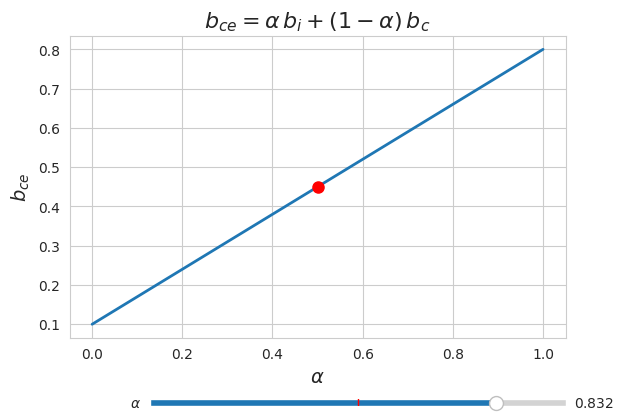

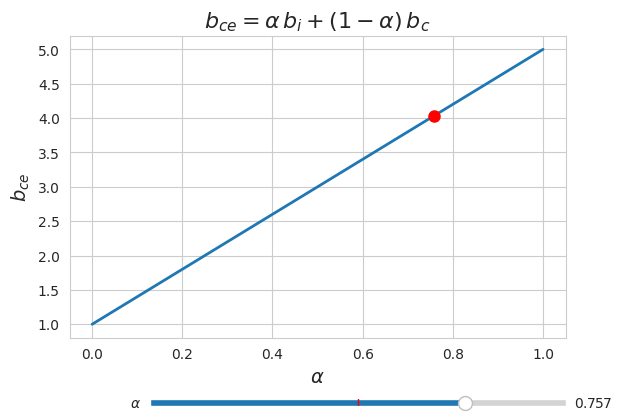

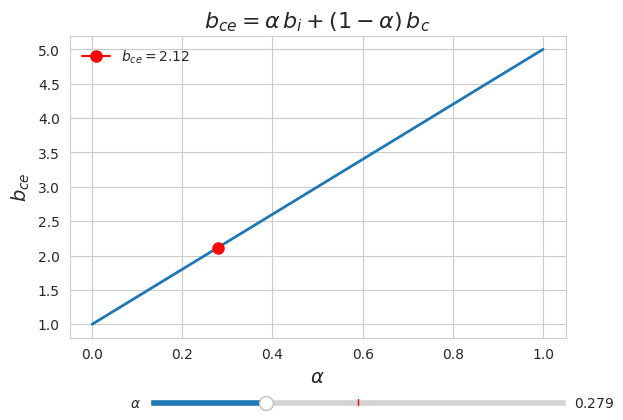

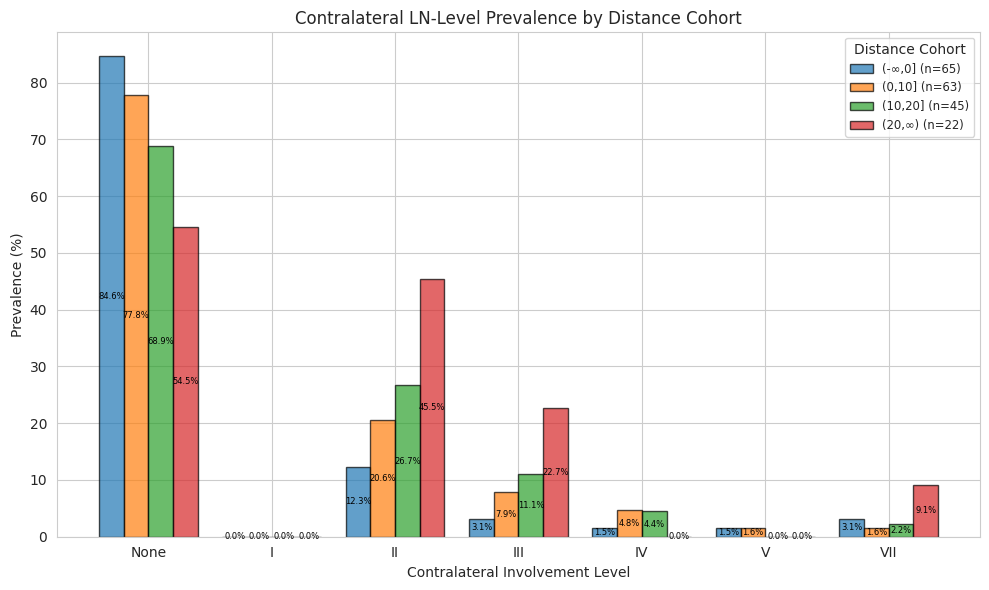

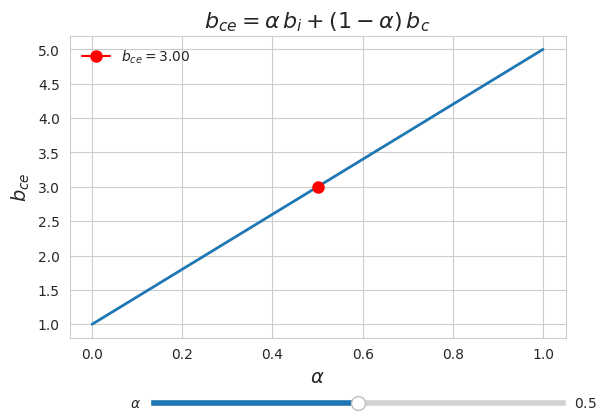

In [64]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib inline

# (Optional) echtes LaTeX aktivieren:
# plt.rcParams['text.usetex'] = True

# Feste Werte
b_i = 5.0
b_c = 1.0

# Alpha-Vektor
alphas = np.linspace(0, 1, 100)
b_ce_all = alphas * b_i + (1 - alphas) * b_c

# Plot aufsetzen
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

ax.plot(alphas, b_ce_all, lw=2)
initial_alpha = 0.5
initial_b_ce = initial_alpha * b_i + (1 - initial_alpha) * b_c

# Punkt als 1-Element-Listen
point, = ax.plot(
    [initial_alpha],
    [initial_b_ce],
    marker='o', markersize=8, color='red'
)

# LaTeX-Achsenbeschriftungen
ax.set_xlabel(r'$\alpha$', fontsize=14)
ax.set_ylabel(r'$b_{ce}$', fontsize=14)
ax.set_title(r'$b_{ce} = \alpha\,b_i + (1-\alpha)\,b_c$', fontsize=16)

# Legende mit initialem b_ce-Wert
legend = ax.legend(
    [point],
    [f"$b_{{ce}} = {initial_b_ce:.2f}$"],
    loc='upper left',
    frameon=False
)

# Slider-Achse
ax_alpha = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(
    ax=ax_alpha,
    label=r'$\alpha$',
    valmin=0.0,
    valmax=1.0,
    valinit=initial_alpha,
)

# Update-Funktion
def update(val):
    alpha = slider.val
    b_ce = alpha * b_i + (1 - alpha) * b_c
    # Punkt neu setzen
    point.set_data([alpha], [b_ce])
    # Legendentext aktualisieren
    legend.texts[0].set_text(f"$b_{{ce}} = {b_ce:.2f}$")
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()


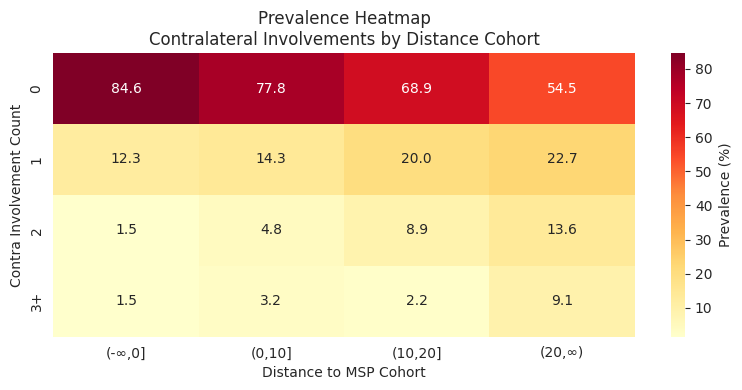

<Figure size 800x400 with 0 Axes>

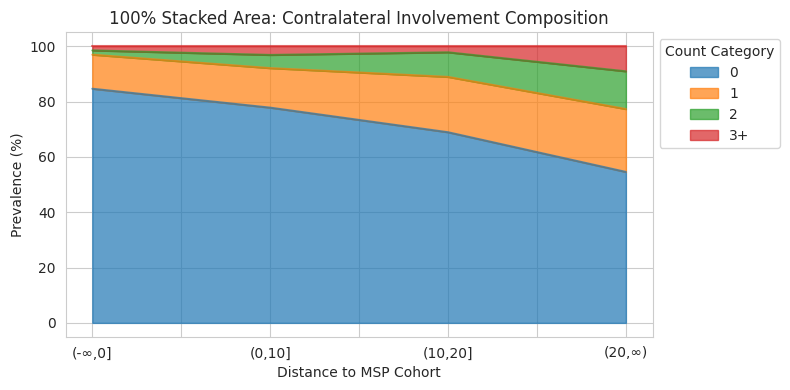

<Figure size 800x400 with 0 Axes>

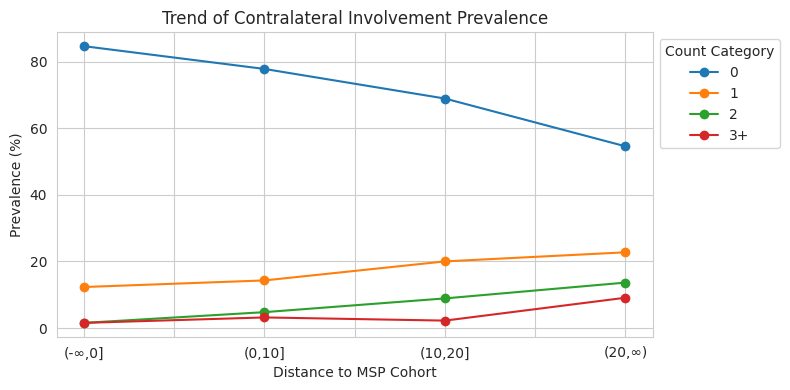

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Load & Prepare Data
# -------------------------------
csv_path = "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv"
df = pd.read_csv(csv_path)

# Ensure numeric and compute "Distance to MSP"
df["Ipsi min d [mm]"]   = pd.to_numeric(df["Ipsi min d [mm]"],   errors="coerce").fillna(0)
df["Contra max d [mm]"] = pd.to_numeric(df["Contra max d [mm]"], errors="coerce").fillna(0)
df["diff"] = df["Contra max d [mm]"] - df["Ipsi min d [mm]"]

# Contralateral involvements as counts
df["contra_inv"] = (
    pd.to_numeric(df["contralateral involvements"], errors="coerce")
      .fillna(0)
      .astype(int)
)

# -------------------------------
# 2. Define cohorts & counts
# -------------------------------
bins      = [-np.inf, 0, 10, 20, np.inf]
coh_labels = ["(-∞,0]","(0,10]","(10,20]","(20,∞)"]
df["cohort"] = pd.cut(df["diff"], bins=bins, labels=coh_labels, right=True)

# We collapse counts >=2 into the category 2
allowed = [0, 1, 2, 3]
inv_labels = ["0", "1", "2", "3+"]

def compute_prevalence(sub):
    """Return a length-3 array of % patients with 0,1,>=2 contralateral nodes."""
    n = len(sub)
    cnts = sub["contra_inv"].clip(upper=3).value_counts().reindex(allowed, fill_value=0)
    return (cnts / (n if n>0 else 1) * 100).values

# build a dict: cohort_label -> [pct0, pct1, pct>=2]
prev = {c: compute_prevalence(df[df["cohort"]==c]) for c in coh_labels}

# Assemble into a DataFrame for plotting
prev_df = pd.DataFrame(prev, index=inv_labels)

# -------------------------------
# 3. Heatmap of prevalence
# -------------------------------
plt.figure(figsize=(8,4))
sns.heatmap(
    prev_df,
    annot=True, fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={"label":"Prevalence (%)"}
)
plt.title("Prevalence Heatmap\nContralateral Involvements by Distance Cohort")
plt.xlabel("Distance to MSP Cohort")
plt.ylabel("Contra Involvement Count")
plt.tight_layout()
plt.show()

# -------------------------------
# 4. 100% Stacked Area Plot
# -------------------------------
plt.figure(figsize=(8,4))
prev_df.T.plot(
    kind="area",
    stacked=True,
    alpha=0.7,
    figsize=(8,4),
    legend=False  # we'll add legend manually
)
plt.ylabel("Prevalence (%)")
plt.xlabel("Distance to MSP Cohort")
plt.title("100% Stacked Area: Contralateral Involvement Composition")
plt.legend(title="Count Category", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Line Plot of Trends
# -------------------------------
plt.figure(figsize=(8,4))
prev_df.T.plot(
    kind="line",
    marker="o",
    figsize=(8,4)
)
plt.ylabel("Prevalence (%)")
plt.xlabel("Distance to MSP Cohort")
plt.title("Trend of Contralateral Involvement Prevalence")
plt.legend(title="Count Category", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


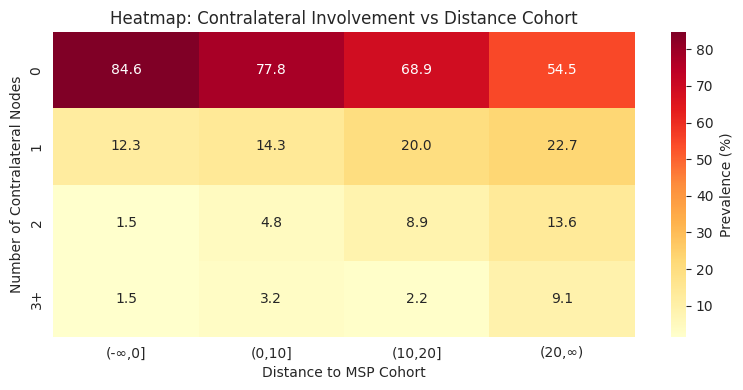

<Figure size 800x400 with 0 Axes>

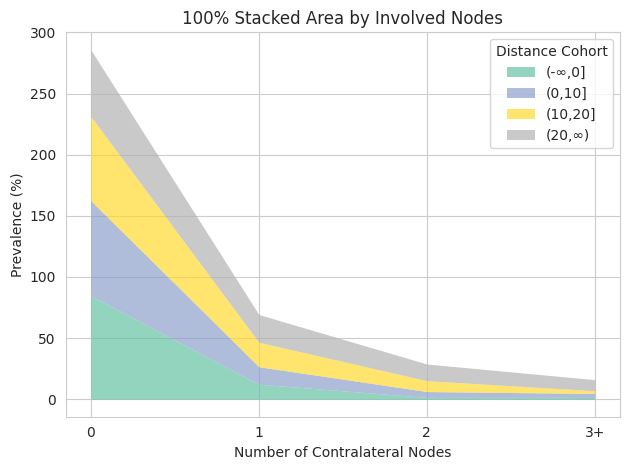

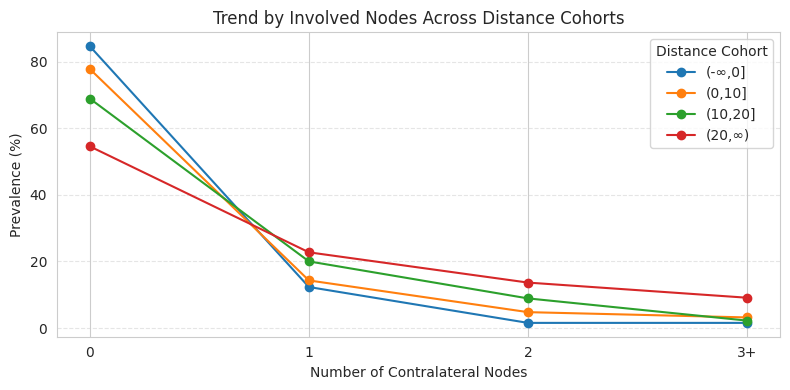

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Load & Prepare Data
# -------------------------------
csv_path = "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv"
df = pd.read_csv(csv_path)

# Ensure numeric and compute "diff"
df["Ipsi min d [mm]"]   = pd.to_numeric(df["Ipsi min d [mm]"],   errors="coerce").fillna(0)
df["Contra max d [mm]"] = pd.to_numeric(df["Contra max d [mm]"], errors="coerce").fillna(0)
df["diff"] = df["Contra max d [mm]"] - df["Ipsi min d [mm]"]

# Contralateral involvements
df["contra_inv"] = (
    pd.to_numeric(df["contralateral involvements"], errors="coerce")
      .fillna(0)
      .astype(int)
)

# -------------------------------
# 2. Define Distance Cohorts
# -------------------------------
bins       = [-np.inf, 0, 10, 20, np.inf]
coh_labels = ["(-∞,0]", "(0,10]", "(10,20]", "(20,∞)"]
df["cohort"] = pd.cut(df["diff"], bins=bins, labels=coh_labels, right=True)

# -------------------------------
# 3. Compute Prevalence per Cohort
# -------------------------------
# collapse >=3 into 3
allowed     = [0, 1, 2, 3]
inv_labels  = ["0", "1", "2", "3+"]

def cohort_prevalence(sub):
    n = len(sub)
    v = sub["contra_inv"].clip(upper=3)
    counts = v.value_counts().reindex(allowed, fill_value=0)
    return (counts / n * 100).values if n>0 else np.zeros(len(allowed))

# build DataFrame: rows = involved‐node count, cols = cohorts
data = {c: cohort_prevalence(df[df["cohort"]==c]) for c in coh_labels}
prev_df = pd.DataFrame(data, index=inv_labels)

# -------------------------------
# 4. Heatmap (unchanged)
# -------------------------------
plt.figure(figsize=(8,4))
sns.heatmap(prev_df, annot=True, fmt=".1f", cmap="YlOrRd",
            cbar_kws={"label":"Prevalence (%)"})
plt.title("Heatmap: Contralateral Involvement vs Distance Cohort")
plt.xlabel("Distance to MSP Cohort")
plt.ylabel("Number of Contralateral Nodes")
plt.tight_layout()
plt.show()

# -------------------------------
# 5. 100% Stacked‐Area (x = involved-node count)
# -------------------------------
plt.figure(figsize=(8,4))
prev_df.plot.area(stacked=True, alpha=0.7, cmap="Set2", linewidth=0)
plt.xticks(range(len(inv_labels)), inv_labels)
plt.xlabel("Number of Contralateral Nodes")
plt.ylabel("Prevalence (%)")
plt.title("100% Stacked Area by Involved Nodes")
plt.legend(title="Distance Cohort", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# -------------------------------
# 6. Line Plot (x = involved-node count)
# -------------------------------
plt.figure(figsize=(8,4))
for cohort in coh_labels:
    plt.plot(inv_labels, prev_df[cohort], marker="o",
             label=f"{cohort}")
plt.xlabel("Number of Contralateral Nodes")
plt.ylabel("Prevalence (%)")
plt.title("Trend by Involved Nodes Across Distance Cohorts")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Distance Cohort", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

def parse_lymphnode_csv(file_path):
    allowed_levels = ["I","II","III","IV","V","VII"]
    with open(file_path, newline="") as f:
        rows = list(csv.reader(f))
    header, side_row, lvl_row = rows[0], rows[1], rows[2]
    data_rows = rows[3:]
    # locate the max_llh columns for each side/level
    ipsi_cols = {
        i:lvl_row[i] 
        for i,col in enumerate(header)
        if col=="max_llh" 
           and side_row[i].lower()=="ipsi" 
           and lvl_row[i] in allowed_levels
    }
    contra_cols = {
        i:lvl_row[i] 
        for i,col in enumerate(header)
        if col=="max_llh" 
           and side_row[i].lower()=="contra" 
           and lvl_row[i] in allowed_levels
    }
    recs = []
    for pid, row in enumerate(data_rows):
        rec = {"Patient": pid}
        # init all to False
        for lvl in allowed_levels:
            rec[f"ipsi_{lvl}"]   = False
            rec[f"contra_{lvl}"] = False
        # fill in True
        for i,lvl in ipsi_cols.items():
            if row[i].strip().lower()=="true":
                rec[f"ipsi_{lvl}"] = True
        for i,lvl in contra_cols.items():
            if row[i].strip().lower()=="true":
                rec[f"contra_{lvl}"] = True
        recs.append(rec)
    return pd.DataFrame(recs)

# 1) parse lymph-node involvement
ln_df = parse_lymphnode_csv("/home/loriskeller/Documents/Master Project/usz_reduced.csv")

# 2) load imaging properties and merge on Patient
prop = pd.read_csv("/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/gtv_properties.csv")
df   = pd.merge(prop, ln_df, on="Patient", how="inner")

# 3) define the levels
levels = ["I","II","III","IV","V","VII"]

# 4) for each side, compute the co-occurrence matrix and plot
for side in ("ipsi","contra"):
    # build empty DataFrame
    co_occur = pd.DataFrame(0, index=levels, columns=levels, dtype=int)
    
    # fill in counts: number of patients where both flags are True
    for lvl1 in levels:
        for lvl2 in levels:
            co_occur.loc[lvl1, lvl2] = int(
                (df[f"{side}_{lvl1}"] & df[f"{side}_{lvl2}"]).sum()
            )
    
    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(
        co_occur,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar_kws={"label": "Number of patients"}
    )
    plt.title(f"{side.capitalize()} LN Level Co-occurrence")
    plt.xlabel("Level")
    plt.ylabel("Level")
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators
import csv

def parse_lymphnode_csv(file_path):
    allowed_levels = ["I","II","III","IV","V","VII"]
    with open(file_path, newline="") as f:
        rows = list(csv.reader(f))
    header, side_row, lvl_row = rows[0], rows[1], rows[2]
    data_rows = rows[3:]
    ipsi_cols = {
        i:lvl_row[i] for i,col in enumerate(header)
        if col=="max_llh" and side_row[i].lower()=="ipsi" and lvl_row[i] in allowed_levels
    }
    contra_cols = {
        i:lvl_row[i] for i,col in enumerate(header)
        if col=="max_llh" and side_row[i].lower()=="contra" and lvl_row[i] in allowed_levels
    }
    recs = []
    for pid, row in enumerate(data_rows, start=0):
        rec = {"Patient": pid}
        for lvl in allowed_levels:
            rec[f"ipsi_{lvl}"]   = False
            rec[f"contra_{lvl}"] = False
        for i,lvl in ipsi_cols.items():
            if row[i].strip().lower()=="true":
                rec[f"ipsi_{lvl}"] = True
        for i,lvl in contra_cols.items():
            if row[i].strip().lower()=="true":
                rec[f"contra_{lvl}"] = True
        recs.append(rec)
    return pd.DataFrame(recs)

# parse our lymph-node CSV
ln_csv = "/home/loriskeller/Documents/Master Project/usz_reduced.csv"
ln_df  = parse_lymphnode_csv(ln_csv)

levels = ["I","II","III","IV","V","VII"]
total = len(ln_df)

for side in ("ipsi", "contra"):
    # build an indicator DataFrame for this side
    df_ind = ln_df[[f"{side}_{lvl}" for lvl in levels]].copy()
    df_ind.columns = levels

    # from_indicators → counts per combination
    upset_data = from_indicators(levels, df_ind)
    # convert to percentages
    upset_data = upset_data

    # plot
    plt.figure(figsize=(8, 5))
    UpSet(
        upset_data,
        show_counts=True,
        sort_by="degree",
        element_size=40,
        facecolor="skyblue"
    ).plot()
    plt.suptitle(f"{side.capitalize()} Side LN-Level Combination Patient Counts", y=1.02)
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

def parse_lymphnode_csv(file_path):
    allowed_levels = ["I","II","III","IV","V","VII"]
    with open(file_path, newline="") as f:
        rows = list(csv.reader(f))
    header, side_row, lvl_row = rows[0], rows[1], rows[2]
    data_rows = rows[3:]
    ipsi_cols = {i:lvl_row[i] for i,col in enumerate(header)
                 if col=="max_llh" and side_row[i].lower()=="ipsi" and lvl_row[i] in allowed_levels}
    contra_cols = {i:lvl_row[i] for i,col in enumerate(header)
                   if col=="max_llh" and side_row[i].lower()=="contra" and lvl_row[i] in allowed_levels}
    recs = []
    for pid, row in enumerate(data_rows, start=0):
        rec = {"Patient": pid}
        for lvl in allowed_levels:
            rec[f"ipsi_{lvl}"] = False
            rec[f"contra_{lvl}"] = False
        for i,lvl in ipsi_cols.items():
            if row[i].strip().lower()=="true": rec[f"ipsi_{lvl}"] = True
        for i,lvl in contra_cols.items():
            if row[i].strip().lower()=="true": rec[f"contra_{lvl}"] = True
        recs.append(rec)
    return pd.DataFrame(recs)

def plot_prevalence_by_level_cohort(
    properties_csv: str,
    ln_csv: str,
    tstage_csv: str,
    property_col: str,
    bins: list,
    bin_labels: list,
    ipsi: bool = False
):
    # 1) load imaging props
    df = pd.read_csv(properties_csv)
    df["Ipsi min d [mm]"]   = pd.to_numeric(df["Ipsi min d [mm]"], errors="coerce").fillna(0)
    df["Contra max d [mm]"] = pd.to_numeric(df["Contra max d [mm]"], errors="coerce").fillna(0)
    if property_col=="distance":
        df["prop"] = df["Contra max d [mm]"] - df["Ipsi min d [mm]"]
        xlabel = "Distance from MSP [mm]"
    else:
        df["prop"] = pd.to_numeric(df[property_col], errors="coerce").fillna(0)
        xlabel = property_col

    # 2) parse LN involvements and merge
    ln_df = parse_lymphnode_csv(ln_csv)
    df = df.merge(ln_df, on="Patient", how="left")

    # 3) load T-stage
    tdf = pd.read_csv(tstage_csv, skiprows=2).iloc[:len(df)]
    df["T-Stage"]     = pd.to_numeric(tdf["t_stage"], errors="coerce").fillna(0).astype(int)
    df["stage_group"] = np.where(df["T-Stage"].isin([1,2]), "early", "late")

    # 4) assign cohorts
    df["cohort"] = pd.cut(df["prop"], bins=bins, labels=bin_labels, right=False)

    # 5) define the exclusive level-categories
    cats = ["None", "II", "II & III", "II & III\n & IV", 
            "II & III & IV\n & V", "II & III & IV\n & V & VII"]
           
    side = "ipsi" if ipsi else "contra"

    def compute_four_exclusive(sub):
        n = len(sub)
        if n == 0:
            return [0, 0, 0, 0]
        fI   = sub[f"{side}_I"].fillna(False).astype(bool)
        fII  = sub[f"{side}_II"].fillna(False).astype(bool)
        fIII = sub[f"{side}_III"].fillna(False).astype(bool)
        fIV  = sub[f"{side}_IV"].fillna(False).astype(bool)
        fV   = sub[f"{side}_V"].fillna(False).astype(bool)
        fVII = sub[f"{side}_VII"].fillna(False).astype(bool)
        none_pct    = (~(fI|fII|fIII|fIV|fV|fVII)).sum()/n*100
        ge1     = (fII & ~(fIII|fIV|fV|fVII)).sum()/n*100
        ge2     = (fII & fIII & ~(fIV|fV|fVII)).sum()/n*100
        ge3     = (fII & fIII & fIV & ~(fV|fVII)).sum()/n*100
        ge4     = (fII & fIII & fIV & fV & ~(fVII)).sum()/n*100
        ge5     = (fII & fIII & fIV & fV & fVII).sum()/n*100
        
        return [none_pct, ge1, ge2, ge3, ge4, ge5]

    overall   = {c: compute_four_exclusive(df[df["cohort"]==c]) for c in bin_labels}
    n_overall = {c: len(df[df["cohort"]==c]) for c in bin_labels}
    split     = {sg:{c: compute_four_exclusive(df[(df["stage_group"]==sg)&(df["cohort"]==c)])
                     for c in bin_labels} for sg in ["early","late"]}
    n_split   = {sg:{c: len(df[(df["stage_group"]==sg)&(df["cohort"]==c)])
                     for c in bin_labels} for sg in ["early","late"]}

    sns.set_style("whitegrid")
    x = np.arange(len(cats))
    total_span = 0.8
    n_cohorts = len(bin_labels)
    width = total_span / n_cohorts
    offsets = (np.arange(n_cohorts) * width) - (total_span - width)/2
    palette = sns.color_palette("Set2", n_colors=n_cohorts)

    # Overall
    fig, ax = plt.subplots(figsize=(8,5))
    for i, c in enumerate(bin_labels):
        vals = overall[c]
        bars = ax.bar(x+offsets[i], vals, width,
                      color=palette[i], edgecolor="black", alpha=0.6,
                      label=f"{c} (n={n_overall[c]})")
        for bar, h in zip(bars, vals):
            ax.text(bar.get_x()+bar.get_width()/2, h/2, f"{h:.1f}%",
                    ha="center", va="center", color="black", fontsize=6)

    ax.set_xticks(x)
    ax.set_xticklabels(cats, rotation=0)
    ax.set_xlim(-0.5, len(cats)-0.5)
    ax.set_xlabel("Level Involvement Category")
    ax.set_ylabel("Patients per level category / Patients in Cohort (%)")
    ax.set_title(f"Overall {side.capitalize()} Involvement in only\n specific levels by {xlabel} Cohort")
    ax.legend(title="Cohort", fontsize="small")
    plt.tight_layout()
    plt.show()

    # Early vs Late
    fig, axes = plt.subplots(1,2,figsize=(12,5), sharey=True)
    for ax, sg in zip(axes, ["early","late"]):
        for i, c in enumerate(bin_labels):
            vals = split[sg][c]
            bars = ax.bar(x+offsets[i], vals, width,
                          color=palette[i], edgecolor="black", alpha=0.6,
                          label=f"{c} (n={n_split[sg][c]})")
            for bar, h in zip(bars, vals):
                ax.text(bar.get_x()+bar.get_width()/2, h/2, f"{h:.1f}%",
                        ha="center", va="center", color="black", fontsize=6)

        ax.set_xticks(x)
        ax.set_xticklabels(cats, rotation=0)
        ax.set_xlabel("Level Involvement Category")
        ax.set_title(f"{sg.capitalize()} T-stage")
        ax.legend(title="Cohort", fontsize="small")
        ax.grid(axis="y")

    axes[0].set_ylabel("Patients per level category / Patients in Cohort (%)")
    plt.suptitle(f"{side.capitalize()} Involvement by {xlabel} Cohort — T-stage Split")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


plot_prevalence_by_level_cohort(
    properties_csv=properties_csv,
    ln_csv=usz_reduced_csv,
    tstage_csv=usz_reduced_csv,
    property_col="distance",
    bins=[-np.inf, 0, 10, 20, np.inf],
    bin_labels=["<=0","(0,10)","(10,20]","(20,∞)"],
    ipsi=False
)

plot_prevalence_by_level_cohort(
    properties_csv=properties_csv,
    ln_csv=usz_reduced_csv,
    tstage_csv=usz_reduced_csv,
    property_col="Contra V [mm^3]",
    bins=[-0.1, 0.1, 1e3, 5e3, np.inf],
    bin_labels=["0","(0,1000]","(1000,5000]","(5000,∞)"],
    ipsi = False
)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

def parse_lymphnode_csv(file_path):
    allowed_levels = ["I","II","III","IV","V","VII"]
    with open(file_path, newline="") as f:
        rows = list(csv.reader(f))
    header, side_row, lvl_row = rows[0], rows[1], rows[2]
    data_rows = rows[3:]
    ipsi_cols = {i:lvl_row[i] for i,col in enumerate(header)
                 if col=="max_llh" and side_row[i].lower()=="ipsi" and lvl_row[i] in allowed_levels}
    contra_cols = {i:lvl_row[i] for i,col in enumerate(header)
                   if col=="max_llh" and side_row[i].lower()=="contra" and lvl_row[i] in allowed_levels}
    recs = []
    for pid, row in enumerate(data_rows, start=0):
        rec = {"Patient": pid}
        for lvl in allowed_levels:
            rec[f"ipsi_{lvl}"] = False
            rec[f"contra_{lvl}"] = False
        for i,lvl in ipsi_cols.items():
            if row[i].strip().lower()=="true": rec[f"ipsi_{lvl}"] = True
        for i,lvl in contra_cols.items():
            if row[i].strip().lower()=="true": rec[f"contra_{lvl}"] = True
        recs.append(rec)
    return pd.DataFrame(recs)

def plot_prevalence_by_level_cohort(
    properties_csv: str,
    ln_csv: str,
    tstage_csv: str,
    property_col: str,
    bins: list,
    bin_labels: list,
    ipsi: bool = False
):
    # 1) load imaging props
    df = pd.read_csv(properties_csv)
    df["Ipsi min d [mm]"]   = pd.to_numeric(df["Ipsi min d [mm]"], errors="coerce").fillna(0)
    df["Contra max d [mm]"] = pd.to_numeric(df["Contra max d [mm]"], errors="coerce").fillna(0)
    if property_col=="distance":
        df["prop"] = df["Contra max d [mm]"] - df["Ipsi min d [mm]"]
        xlabel = "Distance from MSP [mm]"
    else:
        df["prop"] = pd.to_numeric(df[property_col], errors="coerce").fillna(0)
        xlabel = property_col

    # 2) parse LN involvements and merge
    ln_df = parse_lymphnode_csv(ln_csv)
    df = df.merge(ln_df, on="Patient", how="left")

    # 3) load T-stage
    tdf = pd.read_csv(tstage_csv, skiprows=2).iloc[:len(df)]
    df["T-Stage"]     = pd.to_numeric(tdf["t_stage"], errors="coerce").fillna(0).astype(int)
    df["stage_group"] = np.where(df["T-Stage"].isin([1,2]), "early", "late")

    # 4) assign cohorts
    df["cohort"] = pd.cut(df["prop"], bins=bins, labels=bin_labels, right=False)

    # 5) define the exclusive level-categories
    cats = ["None", "II,III,\nIV,V,VII", "III,\nIV,V,VII", "IV,V,VII", "V,VII"]
    # cats = ["None", "I,II", "I,II,III", "I,II,III,\nIV", "I,II,III,\nIV,V", "I,II,III,\nIV,V,VII"]
    side = "ipsi" if ipsi else "contra"

    def compute_six_cumulative(sub, side="contra"):
        n = len(sub)
        if n == 0:
            return [0]*6

        fI   = sub[f"{side}_I"].fillna(False).astype(bool)
        fII  = sub[f"{side}_II"].fillna(False).astype(bool)
        fIII = sub[f"{side}_III"].fillna(False).astype(bool)
        fIV  = sub[f"{side}_IV"].fillna(False).astype(bool)
        fV   = sub[f"{side}_V"].fillna(False).astype(bool)
        fVII = sub[f"{side}_VII"].fillna(False).astype(bool)

        # 0) None
        none = (~(fI|fII|fIII|fIV|fV|fVII)).sum() / n * 100
        # 2) ≥II
        ge2  = (fII|fIII|fIV|fV|fVII).sum() / n * 100
        # 3) ≥III
        ge3  = (fIII|fIV|fV|fVII).sum() / n * 100
        # 4) ≥IV
        ge4  = (fIV|fV|fVII).sum() / n * 100
        # 5) ≥V
        ge5  = (fV|fVII).sum() / n * 100

        # ge1 = (fI|fII).sum() / n * 100
        # ge2 = (fI|fII|fIII).sum() / n * 100
        # ge3 = (fI|fII|fIII|fIV).sum() / n * 100
        # ge4 = (fI|fII|fIII|fIV|fV).sum() / n * 100
        # ge5 = (fI|fII|fIII|fIV|fV|fVII).sum() / n * 100

        return [none, ge2, ge3, ge4, ge5]


    overall   = {c: compute_six_cumulative(df[df["cohort"]==c]) for c in bin_labels}
    n_overall = {c: len(df[df["cohort"]==c]) for c in bin_labels}
    split     = {sg:{c: compute_six_cumulative(df[(df["stage_group"]==sg)&(df["cohort"]==c)])
                     for c in bin_labels} for sg in ["early","late"]}
    n_split   = {sg:{c: len(df[(df["stage_group"]==sg)&(df["cohort"]==c)])
                     for c in bin_labels} for sg in ["early","late"]}

    sns.set_style("whitegrid")
    x = np.arange(len(cats))
    total_span = 0.8
    n_cohorts = len(bin_labels)
    width = total_span / n_cohorts
    offsets = (np.arange(n_cohorts) * width) - (total_span - width)/2
    palette = sns.color_palette("Set2", n_colors=n_cohorts)

    # Overall
    fig, ax = plt.subplots(figsize=(8,5))
    for i, c in enumerate(bin_labels):
        vals = overall[c]
        bars = ax.bar(x+offsets[i], vals, width,
                      color=palette[i], edgecolor="black", alpha=0.6,
                      label=f"{c} (n={n_overall[c]})")
        for bar, h in zip(bars, vals):
            ax.text(bar.get_x()+bar.get_width()/2, h/2, f"{h:.1f}%",
                    ha="center", va="center", color="black", fontsize=6)

    ax.set_xticks(x)
    ax.set_xticklabels(cats, rotation=0)
    ax.set_xlim(-0.5, len(cats)-0.5)
    ax.set_xlabel("Level Involvement Category")
    ax.set_ylabel("Patients per level category / Patients in Cohort (%)")
    ax.set_title(f"Overall {side.capitalize()} Involvement in any \nof the levels by {xlabel} Cohort")
    ax.legend(title="Cohort", fontsize="small")
    plt.tight_layout()
    plt.show()

    # Early vs Late
    fig, axes = plt.subplots(1,2,figsize=(12,5), sharey=True)
    for ax, sg in zip(axes, ["early","late"]):
        for i, c in enumerate(bin_labels):
            vals = split[sg][c]
            bars = ax.bar(x+offsets[i], vals, width,
                          color=palette[i], edgecolor="black", alpha=0.6,
                          label=f"{c} (n={n_split[sg][c]})")
            for bar, h in zip(bars, vals):
                ax.text(bar.get_x()+bar.get_width()/2, h/2, f"{h:.1f}%",
                        ha="center", va="center", color="black", fontsize=6)

        ax.set_xticks(x)
        ax.set_xticklabels(cats, rotation=0)
        ax.set_xlabel("Level Involvement Category")
        ax.set_title(f"{sg.capitalize()} T-stage")
        ax.legend(title="Cohort", fontsize="small")
        ax.grid(axis="y")

    axes[0].set_ylabel("Patients per level category / Patients in Cohort (%)")
    plt.suptitle(f"{side.capitalize()} Involvement by {xlabel} Cohort — T-stage Split")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


plot_prevalence_by_level_cohort(
    properties_csv=properties_csv,
    ln_csv=usz_reduced_csv,
    tstage_csv=usz_reduced_csv,
    property_col="distance",
    bins=[-np.inf, 0, 10, 20, np.inf],
    bin_labels=["<=0","(0,10)","(10,20]","(20,∞)"],
    ipsi=False
)

plot_prevalence_by_level_cohort(
    properties_csv=properties_csv,
    ln_csv=usz_reduced_csv,
    tstage_csv=usz_reduced_csv,
    property_col="Contra V [mm^3]",
    bins=[-0.1, 0.1, 1e3, 5e3, np.inf],
    bin_labels=["0","(0,1000]","(1000,5000]","(5000,∞)"],
    ipsi = False
)



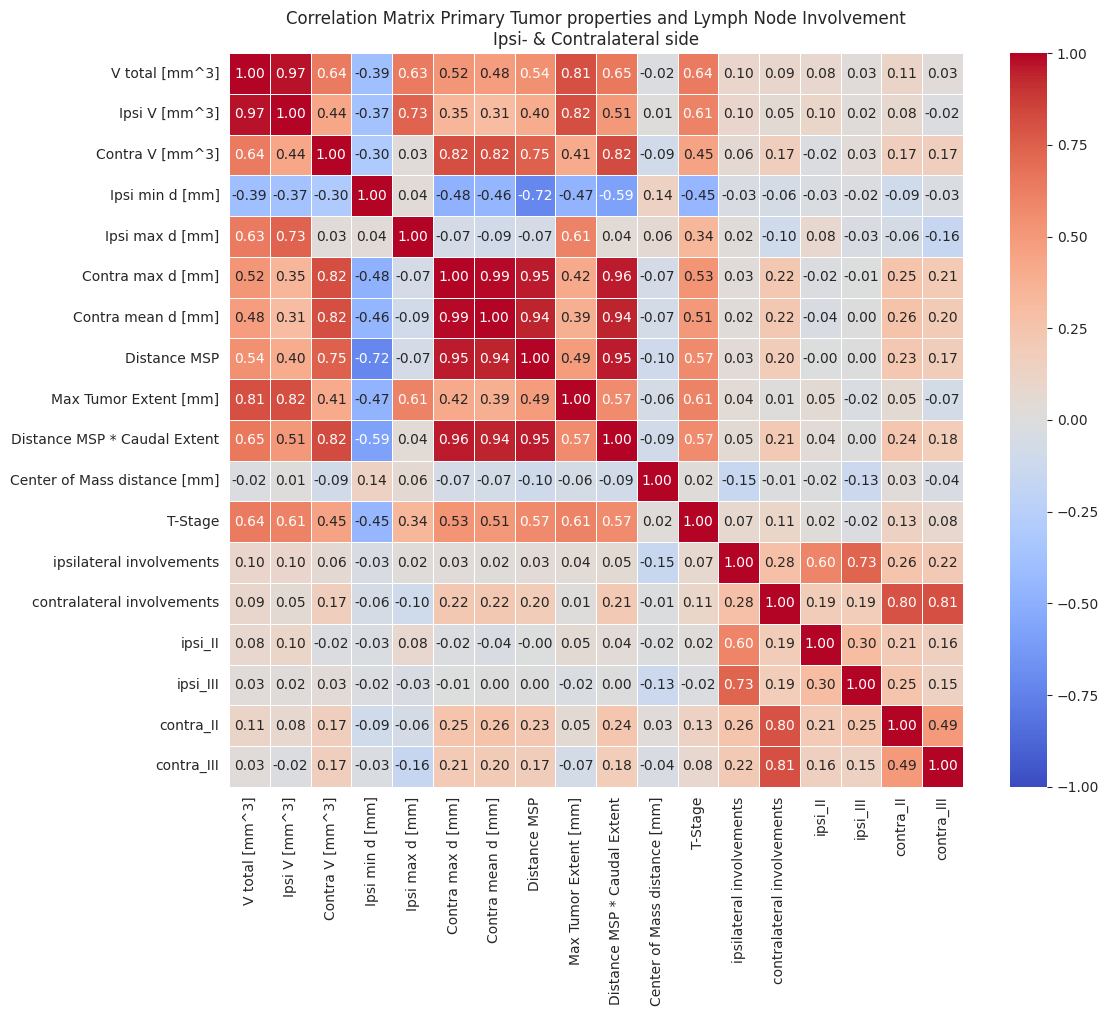

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# -------------------------------
# 1. Load & parse lymph‑node involvement (ipsi & contra for all levels)
# -------------------------------

def parse_lymphnode_csv(file_path):
    allowed_levels = {"I","II","III","IV","V","VII"}
    records = []

    # Read all rows
    with open(file_path, newline="") as f:
        all_rows = list(csv.reader(f))
    header   = all_rows[0]
    side_row = all_rows[1]
    lvl_row  = all_rows[2]
    data_rows = all_rows[3:]  # includes the very last line

    # Build mappings of column→level for ipsi and contra
    info_ipsi = {
        i: lvl_row[i].strip()
        for i,col in enumerate(header)
        if col.strip()=="max_llh"
           and side_row[i].strip().lower()=="ipsi"
           and lvl_row[i].strip() in allowed_levels
    }
    info_contra = {
        i: lvl_row[i].strip()
        for i,col in enumerate(header)
        if col.strip()=="max_llh"
           and side_row[i].strip().lower()=="contra"
           and lvl_row[i].strip() in allowed_levels
    }

    # Enumerate data rows starting at 0
    for pid, row in enumerate(data_rows):
        rec = {"Patient": pid}
        # init flags
        for lvl in allowed_levels:
            rec[f"ipsi_{lvl}"]   = False
            rec[f"contra_{lvl}"] = False
        # fill involvement
        for i,lvl in info_ipsi.items():
            if row[i].strip().lower() == "true":
                rec[f"ipsi_{lvl}"] = True
        for i,lvl in info_contra.items():
            if row[i].strip().lower() == "true":
                rec[f"contra_{lvl}"] = True

        records.append(rec)

    return pd.DataFrame(records)



ln_df = parse_lymphnode_csv("/home/loriskeller/Documents/Master Project/usz_reduced.csv")

# -------------------------------
# 2. Load & Prepare Imaging Data
# -------------------------------
prop = pd.read_csv(
    "/home/loriskeller/Documents/Master Project/VS/Data_extract_and_midline/"
    "Results/14.04.25/Midsagittalplanes Huber delta 300, threshold 300-1500/"
    "gtv_properties.csv"
)
numeric_cols = [
    "Ipsi V [mm^3]", "Contra V [mm^3]", "V total [mm^3]",
    "Ipsi max d [mm]", "Contra max d [mm]",
    "Ipsi min d [mm]", "Max Tumor Extent [mm]", "Contra mean d [mm]"
]
for col in numeric_cols:
    prop[col] = pd.to_numeric(prop[col], errors="coerce").fillna(0)

prop["Distance MSP"] = prop["Contra max d [mm]"] - prop["Ipsi min d [mm]"]
prop["Volume * Extent"] = prop["V total [mm^3]"] * prop["Max Tumor Extent [mm]"]
prop["Distance MSP * Caudal Extent"] = prop["Distance MSP"] * prop["Max distance along plane [mm]"]

prop["ipsilateral involvements"]   = pd.to_numeric(prop["ipsilateral involvements"], errors="coerce").fillna(0).astype(int)
prop["contralateral involvements"] = pd.to_numeric(prop["contralateral involvements"], errors="coerce").fillna(0).astype(int)

# -------------------------------
# 3. Load T‑stage, define early/late
# -------------------------------
clinic_csv = "/home/loriskeller/Documents/Master Project/usz_reduced.csv"
df_clinic  = pd.read_csv(clinic_csv, skiprows=2).iloc[: len(prop)]
prop["T-Stage"]     = pd.to_numeric(df_clinic["t_stage"], errors="coerce").fillna(0).astype(int)
prop["stage_group"] = np.where(prop["T-Stage"].isin([1,2]), "early", "late")

# -------------------------------
# 4. Merge in ipsi_II/contra_II and ipsi_III/contra_III
# -------------------------------

df    = prop.merge(ln_df, on="Patient", how="left")

# -------------------------------
# 5. Compute correlation matrix
# -------------------------------
vars_of_interest = [
    "V total [mm^3]",
    "Ipsi V [mm^3]",
    "Contra V [mm^3]",
    "Ipsi min d [mm]",
    "Ipsi max d [mm]",
    "Contra max d [mm]",
    "Contra mean d [mm]",
    "Distance MSP",
    "Max Tumor Extent [mm]",
    "Distance MSP * Caudal Extent",
    "Center of Mass distance [mm]",
    "T-Stage",
    "ipsilateral involvements",
    "contralateral involvements",
    "ipsi_II",
    "ipsi_III",
    "contra_II",
    "contra_III"
]

corr = df[vars_of_interest].corr()

# -------------------------------
# 6. Plot heatmap
# -------------------------------
plt.figure(figsize=(12,10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    square=True
)
plt.title("Correlation Matrix Primary Tumor properties and Lymph Node Involvement\nIpsi- & Contralateral side")
plt.tight_layout()
plt.show()
